SwatGrains 2020 Data Analysis: BondInfo.txt file - Contact Networks and Force Distribution
==============

## 0.1 Imports and Functions
The first run. Includes all the consistently used packages for this notebook, as well as useful functions like `read_data()`, `sort_particles()`, etc. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
import matplotlib
import pandas as pd
import os

def read_data(filename):
    # reads BondInfo.txt files into friendly DataFrames.
    dataset=pd.read_csv(filename, usecols=range(7), sep=' ', header=0, names=['x1','y1','x2','y2','energy','force','bondType']) # read bondInfo.txt
    dataset['trialName']=dataset.groupby((dataset.x1=='>>>>>').cumsum())['y1'].transform(lambda x: x.max()) # group by trial dividers, recognized by >>>>>, and label each row with group name
    dataset = dataset[dataset.x1 != '>>>>>'].reset_index(drop=True) # remove trial dividers

    # Generate higher level index
    dataset.index.rename('rowNumber', inplace=True)
    dataset.set_index('trialName',append=True,inplace=True)
    dataset.index=dataset.index.swaplevel()
    dataset=dataset.astype('float32') # convert all columns to float32 - 7 decimal places of precision is plenty
    dataset['bondType']=dataset['bondType'].astype('int16') # except bond type, which is a column of integers
    dataset['normalizedForce']=dataset.groupby('trialName')['force'].transform(lambda x: x/x.mean())
    dataset[['x1','y1','x2','y2','normalizedForce']]=(1e6*dataset[['x1','y1','x2','y2','normalizedForce']]).astype('int')
    return dataset

def get_pressures(filename):
    # the Pressures.txt file (created in Info_Analysis.ipynb) contains the seeds of all jammed trials, which we use to filter our data.
    # for some of our analysis, we'll also need pressures corresponding to each trial, which this file gives us.
    filePath=filename.split('/')
    filePath[-1]=filePath[-1].replace('BondInfo','Pressures')
    trialPressures=pd.read_csv('/'.join(filePath), sep=' ', index_col=0)['pressure']
    return trialPressures

def get_angles(filename):
    # pulls the corresponding BondAngle.txt and formats indices to be compatible with BondInfo DataFrame.
    filePath=filename.split('/')
    filePath[-1]=filePath[-1].replace('Info','Angles')
    bondAngles=pd.read_csv('/'.join(filePath), header=0, names=['bond_angles'], squeeze=True) # read BondAngles.txt raw, just returns rows as entries of a series
    bondAngles=bondAngles.str.split(expand=True) # split each series entry by space and expand into columns
    bondAngles['trialName']=bondAngles.groupby((bondAngles[0]=='>>>>>').cumsum())[1].transform(lambda x: x.max()) # group by trial dividers, recognized by >>>>>, and label each row with group name
    bondAngles=bondAngles[bondAngles[0]!='>>>>>']
    bondAngles.set_index('trialName', inplace=True)
    bondAngles=bondAngles.astype('float32')
    bondAngles=bondAngles.stack().rename('bondAngle').reset_index().drop('level_1', axis=1).set_index('trialName', append=True)
    bondAngles.index=bondAngles.index.swaplevel()
    return bondAngles

def sort_particles(dataset, types=[0,1,2]):
    # same function as is used in cell 2.1 - sort particles into types via bondType column.
    # returns a dataframe of every coordinate in bondInfo - duplicates included.
    small_mobile=[]
    large_mobile=[]
    pins=[]

    for bondGroup in dataset.groupby('bondType'):
        coords1=bondGroup[1][['x1','y1']].rename(columns={'x1':'x','y1':'y'})
        coords2=bondGroup[1][['x2','y2']].rename(columns={'x2':'x','y2':'y'})
        # case-by-case for each bond type
        if bondGroup[0]==0:
            # small-small
            small_mobile.extend([coords1,coords2]) # extend() is just append() with multiple items

        if bondGroup[0]==1:
            # small-large
            small_mobile.append(coords1)
            large_mobile.append(coords2)

        if bondGroup[0]==2:
            # large-large
            large_mobile.extend([coords1,coords2])

        if bondGroup[0]==3:
            # pin-small
            small_mobile.append(coords2)
            pins.append(coords1)

        if bondGroup[0]==4:
            # pin-large
            large_mobile.append(coords2)
            pins.append(coords1)

    large_mobile=pd.concat(large_mobile)
    small_mobile=pd.concat(small_mobile)
    pins=pd.concat(pins)

    sortedFrame=pd.concat([large_mobile.assign(particleType=2),small_mobile.assign(particleType=1), pins.assign(particleType=0)])
    return  sortedFrame[sortedFrame.particleType.isin(types)] # return combined dataframes, with additional column for type

def bond_location(bondInfo, bondType):
    if bondType==0 or bondType==2:
        CoM = 1/2
    elif bondType==1:
        CoM = 1/(1+1.4)
    elif bondType==3 or bondType==4:
        CoM = 0

    #print('\t \t finding wrappers:')
    wrapsX=bondInfo[np.abs(bondInfo.x1-bondInfo.x2)>=0.5].copy() # 0.5*1e6 is kind of arbitrary here, all that matters is distance > (R_A+R_B)
    wrapsY=bondInfo[np.abs(bondInfo.y1-bondInfo.y2)>=0.5].copy()
    unwrapped = bondInfo.drop(np.append(wrapsX.index.values,wrapsY.index.values))
    wrapsX['xAdjust']=round(wrapsX['x1']-wrapsX['x2'])
    wrapsY['yAdjust']=round(wrapsY['y1']-wrapsY['y2'])
    #print('\t \t finding corners:')

    # Additional case for when bonds wrap through three regions via corner
    cornerIndex=wrapsX.index.intersection(wrapsY.index) # slight "optimization:" rather than merge the data twice, we get the adjustment parameters for corners twice
    wrapsCorner=bondInfo.loc[cornerIndex]
    wrapsCorner['xAdjust']=round(wrapsCorner['x1']-wrapsCorner['x2'])
    wrapsCorner['yAdjust']=round(wrapsCorner['y1']-wrapsCorner['y2'])

    # Separate corner cases from edge cases (they'll plot differently)
    wrapsX=wrapsX.drop(cornerIndex)
    wrapsY=wrapsY.drop(cornerIndex)
    #print('\t \t handling wraps:')
    # X-wrapped lines
    unwrappedX=pd.concat([wrapsX.assign(x1=wrapsX.x1-wrapsX.xAdjust),wrapsX.assign(x2=wrapsX.x2+wrapsX.xAdjust)])
    unwrappedY=pd.concat([wrapsY.assign(y1=wrapsY.y1-wrapsY.yAdjust),wrapsY.assign(y2=wrapsY.y2+wrapsY.yAdjust)])
    #print('\t \t handling corners:')
    # Corner-wrapped lines
    unwrappedCorner=[]
    for i in [0,1]: # 2x2 loop (one run for each corner)
        for j in [0,1]:
            unwrappedCorner.extend([wrapsCorner.assign(x1=wrapsCorner.x1+wrapsCorner.xAdjust*(i-1), y1=wrapsCorner.y1+wrapsCorner.yAdjust*(j-1), x2=wrapsCorner.x2+wrapsCorner.xAdjust*i, y2=wrapsCorner.y2+wrapsCorner.yAdjust*j)])
    unwrappedCorner=pd.concat(unwrappedCorner)
    #print('\t \t finding interfaces:')
    unwrapped=pd.concat([unwrapped, unwrappedX, unwrappedY, unwrappedCorner])
    ret = pd.DataFrame({'x':(1-CoM)*unwrapped.x1+CoM*unwrapped.x2, 'y':(1-CoM)*unwrapped.y1+CoM*unwrapped.y2, 'force':unwrapped.normalizedForce})
    try:
        ret['angle'] = unwrapped.bondAngle
    except:
        pass
    ret['bondColor'] = 'C'+str(bondType)
    return ret

filenames={'non0_07-11':'simulation_data/non_BondInfo07-11.txt', 'non0_07-13':'simulation_data/non_BondInfo07-13.txt',
           'non0_08-02':'simulation_data/ZeroPinData/non_BondInfo08-02.txt', 'non0_06-20':'simulation_data/ZeroPinData/non_BondInfo06-20.txt',
           'squ16_08-05':'simulation_data/squ_BondInfoNp16_08-05.txt', 'squ64_08-05':'simulation_data/squ_BondInfoNp64_08-05.txt','squ36_07-11':'simulation_data/squ_BondInfo07-11.txt',
           'squ64_07-12':'simulation_data/squ_BondInfo07-12.txt', 'squ64_07-13':'simulation_data/squ_BondInfo07-13.txt',
           'tri36_07-11':'simulation_data/tri_BondInfo07-11.txt', 'tri64_08-08':'simulation_data/tri_BondInfoNp64_08-08.txt', 'tri64_07-12':'simulation_data/tri_BondInfo07-12.txt',
           'ran36_07-11':'simulation_data/ran_BondInfo07-11.txt', 'squ100_07-19':'simulation_data/squ_BondInfo07-19.txt', 'tri100_07-19':'simulation_data/tri_BondInfo07-19.txt', 'ran100_07-19':'simulation_data/ran_BondInfo07-19.txt',
           'squ36_08-05':'simulation_data/squ_BondInfo08-05_36.txt', 'squ49_08-06':'simulation_data/squ_BondInfo08-06_49.txt',
           'tri36_08-08':'simulation_data/tri_BondInfo08-08_36.txt', 'tri49_08-08':'simulation_data/tri_BondInfo08-08_49.txt', 
           'tri16_08-08':'simulation_data/tri_BondInfoNp16_08-08.txt',
           'non0_11-23:02':'simulation_data/nov_23/non_BondInfo_2.011-23.txt','non0_11-23:04':'simulation_data/nov_23/non_BondInfo_4.011-23.txt','non0_11-23:06':'simulation_data/nov_23/non_BondInfo_6.011-23.txt',
           'squ64_02-17:02':'simulation_data/feb_17/squ_BondInfo_2.002-17.txt','squ64_02-17:04':'simulation_data/feb_17/squ_BondInfo_4.002-17.txt','squ64_02-17:06':'simulation_data/feb_17/squ_BondInfo_6.002-17.txt',
           'squ256_02-18:02':'simulation_data/feb_18/squ_BondInfo_2.002-18.txt','squ256_02-18:04':'simulation_data/feb_18/squ_BondInfo_4.002-18.txt','squ256_02-18:06':'simulation_data/feb_18/squ_BondInfo_6.002-18.txt'}


## 0.2. Load Data

Loads a set of bondInfo.txt files as hierarchically indexed DataFrames, which contain each jammed trial indexed by trial name and original row number. DataFrames are stored in the dictionary `dataDict`, and are indexed by abbreviated file names for easier iteration.

In [ ]:
# July Data
#files = ['non0_07-11','squ36_07-11', 'squ64_07-12', 'squ100_07-19','ran36_07-11','ran100_07-19', 'tri36_07-11', 'tri64_07-12', 'tri100_07-19']

# good zero-pins
#files = ['non0_07-11', 'non0_08-02', 'non0_06-20']

# all squares
#files=['non0_08-02','squ16_08-05','squ64_08-05','squ36_07-11','squ64_07-12','squ64_07-13','squ100_07-19','squ36_08-05','squ49_08-06']

# good squares
files=['squ16_08-05','squ36_08-05','squ49_08-06','squ64_08-05','squ100_07-19']

# low pressure
#files=['squ64_02-17:02','squ64_02-17:04','squ64_02-17:06','squ256_02-18:02','squ256_02-18:04','squ256_02-18:06','non0_11-23:02','non0_11-23:04','non0_11-23:06']

# lowest pressure
#files=['non0_11-23:06','squ64_02-17:06','squ256_02-18:06']

# triangles
#files=['tri36_07-11','tri64_08-08','tri64_07-12','tri100_07-19','tri36_08-08','tri49_08-08','tri16_08-08']

# all
#files = filenames.keys()

dataDict={file:read_data(filenames[file]) for file in files}

# 1. Contact Numbers

## 1.1. dfContacts
Creates the DataFrame `dfContacts`, which identifies each particle with its corresponding number of contacts, indexed by particle type (pin, small, large). This is a prequisite for Cell 1.2.

In [ ]:
contactsDict={file:sort_particles(dataDict[file]).groupby(['x','y','particleType','trialName']).size().reset_index(name='contacts').set_index('particleType') for file in files} # dataframe of particle coordinates, with contact number and trial labeled

## 1.2. Extrapolate $z_c$ as pressure goes to 0
Fitting $z(P)$ to a power function. We expect $\Delta Z\propto\Delta\phi^{1/2},$ and by extension
$$Z(P)=c\sqrt{P}+Z_\text{C},$$
where $Z_C$ is the critical contact number and  $c$ is (we hope) some unit-dependent constant.

### 1.2.1 Fitting all the data

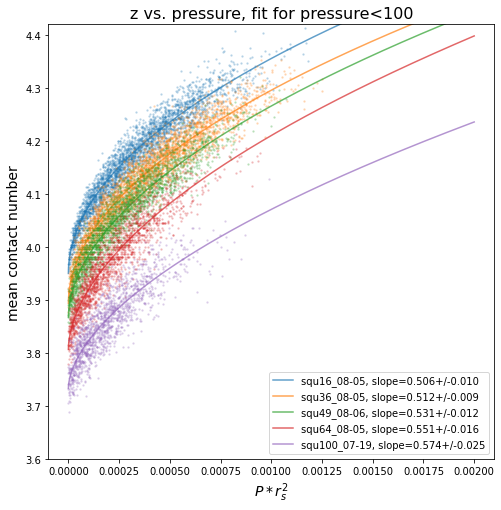

In [ ]:
import re
def power_fit(xdata, coeff, power, intercept):
    return coeff*(xdata)**power+intercept

upperCutoff=100
contactParameters=[]
intercepts=[]
plt.figure(figsize=(8,8))
for colorCounter, file in enumerate(files):
    fileData=np.array(dataDict[file].index.get_level_values(0)[0].split('-')[2:]).astype('float')
    #print(colorCounter)
    meanContacts=contactsDict[file].loc[[1,2]].groupby('trialName')['contacts'].mean()
    pressureData = pd.concat([get_pressures(filenames[file]),meanContacts], axis=1).dropna()
    pressureData.index.name='trialName'
    [coeff,power, intercept], covariance = sp.curve_fit(power_fit, pressureData.loc[pressureData.pressure<upperCutoff, 'pressure'], pressureData.loc[pressureData.pressure<upperCutoff, 'contacts'])
    perror=np.sqrt(np.diag(covariance))
    plt.plot(pressureData['pressure'], pressureData['contacts'],'C{}.'.format(colorCounter%9), ms=3, alpha=0.2)
    xValues=np.linspace(0,0.002,10000)
    yValues=power_fit(xValues, coeff, power, intercept)
    plt.plot(xValues,yValues, 'C{}'.format(colorCounter%9), alpha=0.7, label='{name}, slope={p:.3f}+/-{perr:.3f}'.format(name=file, p=power,perr=perror[1]))#, $z_c={z:.3f}+/-{err:.3f}$, power=${a:.4f}+/-{err2:.3f}$'.format(name=file, z=intercept,err=perror[2],a=power, err2=perror[1]))
    intercepts.append(intercept)
    if file[:3]=='non':
        fileData[-2]=0
    if file[:3]=='tri':
        g=np.sqrt(3)/2
    else:
        g=1
    contactParameters.append(pd.DataFrame({'n_pins':fileData[1],'n_total':fileData[0],'lambda':fileData[-2]/fileData[-1],'alpha':np.pi*(1+1.4**2)/(2*g)*(fileData[-2]/fileData[-1])**2,'coeff': coeff, 'err1': perror[0], 'power': power, 'err2': perror[1], 'intercept': intercept, 'err3':perror[2], 'geo':file[:3]}, index=[file]))
    # Export delta z values to Pressures.txt file for plotting in Info_Analysis.ipynb
    #pressurePath=filenames[file].split('/')
    #pressurePath[-1]=pressurePath[-1].replace('BondInfo','Pressures')
    #pressureData['delta_z']=pressureData['contacts']-intercept
    #pressureData.drop('contacts', axis=1, inplace=True)
    #pressureData.to_csv('/'.join(pressurePath), sep=' ')

contactParameters=pd.concat(contactParameters)
plt.ylabel('mean contact number', fontsize=14)
#plt.axvspan(0,upperCutoff, color='green', alpha=0.1) # highlight region being fitted
plt.xlabel('$P*r_s^2$', fontsize=14)
plt.legend()
plt.title('z vs. pressure, fit for pressure<{}'.format(upperCutoff), fontsize=16)#.format(num=int(dfContacts.groupby('trialName').size().mean()),z=intercept, err=perror[1]))
plt.ylim(3.6,4.42)
#plt.savefig('plots/z_vs_p-lowest_pressure.jpg', dpi=300)

plt.show()

### 1.2.1 Fitting data binned and averaged by pressure range

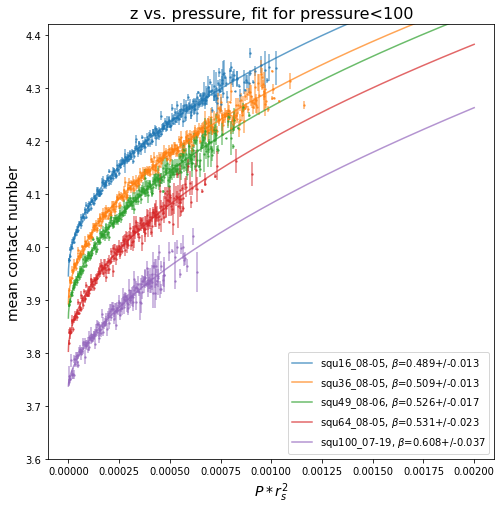

In [ ]:
import re
def power_fit(xdata, coeff, power, intercept):
    return coeff*(xdata)**power+intercept

upperCutoff=100
contactParameters=[]
intercepts=[]
plt.figure(figsize=(8,8))
for colorCounter, file in enumerate(files):
    fileData=np.array(dataDict[file].index.get_level_values(0)[0].split('-')[2:]).astype('float')
    #print(colorCounter)
    meanContacts=contactsDict[file].loc[[1,2]].groupby('trialName')['contacts'].mean()
    pressureData = pd.concat([get_pressures(filenames[file]),meanContacts], axis=1).dropna()
    pressureData.index.name='trialName'
    pressureData = pressureData.groupby(pd.cut(pressureData['pressure'], np.linspace(0,0.003,1000))).agg({'contacts':['mean','sem']}).dropna()
    pressureData['midpressure'] = pd.arrays.IntervalArray(pressureData.index).mid
    [coeff,power, intercept], covariance = sp.curve_fit(power_fit, pressureData.loc[pressureData.midpressure<upperCutoff, 'midpressure'], pressureData.loc[pressureData.midpressure<upperCutoff, 'contacts']['mean'])
    perror=np.sqrt(np.diag(covariance))
    plt.errorbar(pressureData['midpressure'], pressureData['contacts', 'mean'],yerr=pressureData['contacts','sem'],fmt='C{}.'.format(colorCounter%9), ms=3, alpha=0.6)
    xValues=np.linspace(0,0.002,10000)
    yValues=power_fit(xValues, coeff, power, intercept)
    plt.plot(xValues,yValues, 'C{}'.format(colorCounter%9), alpha=0.7, label=r'{name}, $\beta$={p:.3f}+/-{perr:.3f}'.format(name=file, p=power,perr=perror[1]))#, $z_c={z:.3f}+/-{err:.3f}$, power=${a:.4f}+/-{err2:.3f}$'.format(name=file, z=intercept,err=perror[2],a=power, err2=perror[1]))
    intercepts.append(intercept)
    if file[:3]=='non':
        fileData[-2]=0
    if file[:3]=='tri':
        g=np.sqrt(3)/2
    else:
        g=1
    contactParameters.append(pd.DataFrame({'n_pins':fileData[1],'n_total':fileData[0],'lambda':fileData[-2]/fileData[-1],'alpha':np.pi*(1+1.4**2)/(2*g)*(fileData[-2]/fileData[-1])**2,'coeff': coeff, 'err1': perror[0], 'power': power, 'err2': perror[1], 'intercept': intercept, 'err3':perror[2], 'geo':file[:3]}, index=[file]))
    # Export delta z values to Pressures.txt file for plotting in Info_Analysis.ipynb
    #pressurePath=filenames[file].split('/')
    #pressurePath[-1]=pressurePath[-1].replace('BondInfo','Pressures')
    #pressureData['delta_z']=pressureData['contacts']-intercept
    #pressureData.drop('contacts', axis=1, inplace=True)
    #pressureData.to_csv('/'.join(pressurePath), sep=' ')
contactParameters=pd.concat(contactParameters)
plt.ylabel('mean contact number', fontsize=14)
#plt.axvspan(0,upperCutoff, color='green', alpha=0.1) # highlight region being fitted
plt.xlabel('$P*r_s^2$', fontsize=14)
plt.legend()
plt.title('z vs. pressure, fit for pressure<{}'.format(upperCutoff), fontsize=16)#.format(num=int(dfContacts.groupby('trialName').size().mean()),z=intercept, err=perror[1]))
plt.ylim(3.6,4.42)
#plt.savefig('plots/z_vs_p-binned_errorbars.jpg', dpi=300)

plt.show()

## 1.3 Contact number analysis

### 1.3.1 Plotting contact number parameters vs. $\alpha$

In [ ]:
plt.figure(figsize=(8,6))
for geo in contactParameters.sort_values(by='lambda').groupby('geo'):
    if geo[0]=='ran':
        marker='d'
    elif geo[0]=='non':
        marker='X'
    elif geo[0]=='squ':
        marker='s'
    elif geo[0]=='tri':
        marker='^'
    plt.errorbar(geo[1]['alpha'], geo[1]['coeff'], yerr=geo[1]['err1'], fmt=' ', capsize=5, marker=marker, alpha=0.6, label=geo[0])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'c')
plt.title(r'fit coefficient vs. $\alpha,$ fit for pressure<{}'.format(upperCutoff))
plt.yscale('log')
plt.legend(loc='upper left')

#plt.savefig('plots/beta_vs_alpha-lowest_pressure.jpg', dpi=300)
plt.show()

### 1.3.2 Plotting contact number parameters vs. $\lambda$

In [ ]:
plt.figure(figsize=(6,6))
for geo in contactParameters.groupby('geo'):
    if geo[0]=='non':
        marker='X'
    elif geo[0]=='squ':
        marker='s'
    elif geo[0]=='tri':
        marker='^'
    elif geo[0]=='ran':
        marker='d'
    plt.errorbar(geo[1]['lambda'], geo[1]['intercept'], yerr=geo[1]['err2'], fmt=marker, alpha=0.6, label=geo[0])

plt.legend()
plt.ylabel('$z_c$')
plt.xlabel(r'$\lambda$')
plt.title(r'critical $z$ vs $\lambda$')
#plt.savefig('plots/z_c_vs_lambda.jpg', dpi=300)
plt.show()

## 1.4. (Deprecated). Finding contact number with NetworkX
After failing to effectively plot topology with NetworkX, we revisited the module, attempting to use its graph.neighbors() function to find contact numbers without too much fuss. Unfortunately, NetworkX is not well-suited to such large data sets, and this script, while theoretically functional, ends up being incredibly inefficient and has never finished running.

In [ ]:
import networkx as nx

contactNumbers=[]
entireFile['sourceNodes']=entireFile['x1'].round(6).astype('str')+' '+entireFile['y1'].round(6).astype('str')
entireFile['targetNodes']=entireFile['x2'].round(6).astype('str')+' '+entireFile['y2'].round(6).astype('str')
list_of_trials=entireFile.index.get_level_values('trialName')
for trial in list_of_trials:
#trialName=entireFile.index.get_level_values('trialName')[0] # get name of first trial
#headerNames=['geometry','seed','num','pins','small_radius','something'] # TODO: what is this last value in the header? pin spacing?
#trialInfo={}
#for key, label in zip(headerNames,trialName.split('-')): # retrieve info from name
#    trialInfo[key]=label
    bondInfo=entireFile.loc[[trial]]

    #print(bondInfo['sourceNodes'])
    network=nx.from_pandas_edgelist(bondInfo,'sourceNodes','targetNodes',edge_attr=True)

    nonPinEdges=[(node1,node2) for (node1,node2, data) in network.edges(data=True) if data['bondType']<3]
    nonPinGraph=nx.Graph(nonPinEdges)
    #print("average number of contact (no pins):", 2*nonPinGraph.number_of_edges()/nonPinGraph.number_of_nodes())
    #print("average number of contact (with pins):)", 2*network.number_of_edges()/network.number_of_nodes())
    meanContacts=2*nonPinGraph.number_of_edges()/nonPinGraph.number_of_nodes()
    for node in nonPinGraph.nodes:
        contactNumbers.append(len(list(nonPinGraph.neighbors(node))))

plt.hist(contactNumbers, bins=np.linspace(min(contactNumbers)-0.25,max(contactNumbers)+0.25, (max(contactNumbers)-min(contactNumbers)+1)*2),color='C0')
plt.title('Contact number barplot for {} lattice of {} pins, mean = {}'.format(trialInfo['geometry'],trialInfo['pins'],meanContacts))
plt.xlabel('Contact Number')
#plt.savefig('plots/contact_barplot_{}{}.png'.format(*[trialInfo[x] for x in ['geometry','pins']]), dpi=300)
plt.show()

## 1.5.1 $N_{excess}$ vs. Number of Particle-Particle Contacts

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


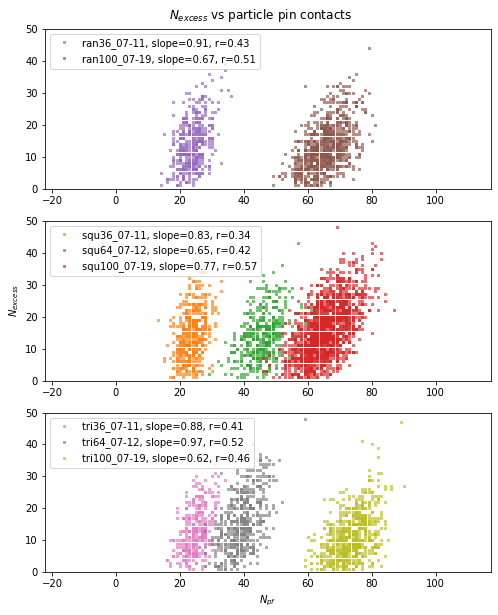

In [ ]:
#import matplotlib
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
from scipy import stats
# What's really important: picking a fun color scheme
#colormap = matplotlib.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 'r', '#FFFFFF', '#FFFFFF']) # classic
#colormap = matplotlib.cycler('color',['#FAD55C','#68C182','#267DB3','#ED6647','#8561C8','#000000', '#fef9e6', '#c0dff2']) # blue-yellow
#plt.rc('axes',prop_cycle=colormap)

fig, (axRan, axSqu, axTri) = plt.subplots(3,1,figsize=(8,10))
for colorCounter, file in enumerate(files):
    if file[:3]!='non':
        N_pp=dataDict[file][dataDict[file].bondType<=2].groupby(level=0).size()
        N_pf=dataDict[file][dataDict[file].bondType>=3].groupby(level=0).size()
        num_particles=sort_particles(dataDict[file], types=[1,2]).drop_duplicates(keep='first').groupby('trialName').size()
        N_excess=N_pp+N_pf-2*num_particles-1
        N_pf=N_pf[N_excess>0]
        N_excess=N_excess[N_excess>0]
        regression=stats.linregress(N_pf,N_excess)
        yValues=np.array([0,50])
        xValues=(yValues-regression[1])/regression[0]
        if file[:3]=='ran':
            axRan.plot(N_pf, N_excess, 's', ms=2, label='{}, slope={slope:.2f}, r={r:.2f}'.format(file, slope=regression[0], r=regression[2]), alpha=0.6, color='C{}'.format(colorCounter))
            axRan.plot(xValues,yValues, color='C{}'.format(colorCounter))
        elif file[:3]=='squ':
            axSqu.plot(N_pf, N_excess, 's', ms=2, label='{}, slope={slope:.2f}, r={r:.2f}'.format(file, slope=regression[0], r=regression[2]), alpha=0.6, color='C{}'.format(colorCounter))
            axSqu.plot(xValues,yValues, color='C{}'.format(colorCounter))
        elif file[:3]=='tri':
            axTri.plot(N_pf, N_excess, 's', ms=2, label='{}, slope={slope:.2f}, r={r:.2f}'.format(file, slope=regression[0], r=regression[2]), alpha=0.6, color='C{}'.format(colorCounter))
            axTri.plot(xValues,yValues, color='C{}'.format(colorCounter))

for axis in [axRan,axSqu,axTri]:
    axis.set(aspect='equal',adjustable='datalim')
    axis.set_xlim(0,95)
    axis.set_ylim(0,50)
    axis.legend(loc='upper left')

plt.xlabel('$N_{pf}$')
axSqu.set_ylabel('$N_{excess}$')
fig.suptitle('$N_{excess}$ vs. particle pin contacts', y=0.91
)
#plt.savefig('plots/Nexcess_vs_Npf-July20-regressed.png', dpi=300)
plt.show()

## 1.5.2 $N_{excess}$ vs. Pressure

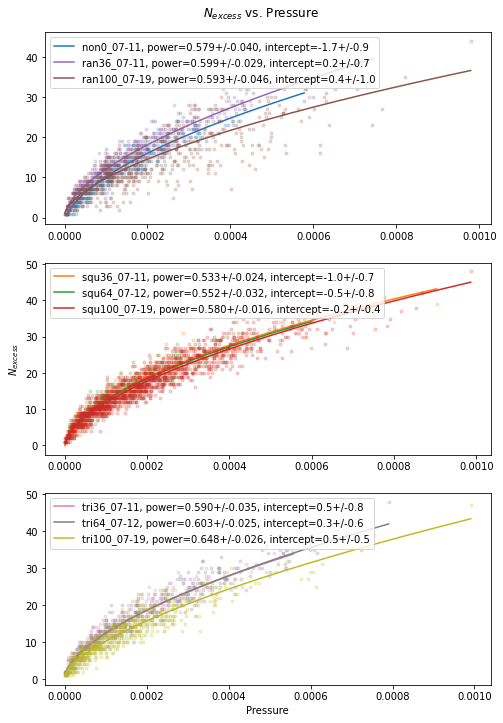

In [ ]:
def power_fit(xdata, coeff, power, intercept):
    return coeff*(xdata)**power+intercept

fig, (axRan, axSqu, axTri) = plt.subplots(3,1,figsize=(8,12))
for colorCounter, file in enumerate(files):
    N_total=dataDict[file].groupby(level=0).size()
    num_particles=sort_particles(dataDict[file], types=[1,2]).drop_duplicates(keep='first').groupby('trialName').size()
    N_excess=N_total-2*num_particles-1
    N_excess=N_excess[N_excess>0].rename('N_excess')
    pressure_and_excess=pd.concat([get_pressures(filenames[file]), N_excess], axis=1).dropna()
    [coeff,power, intercept], covariance = sp.curve_fit(power_fit, pressure_and_excess['pressure'], pressure_and_excess['N_excess'])
    xValues=np.array(np.linspace(pressure_and_excess['pressure'].min(), pressure_and_excess['pressure'].max(), 1000))
    yValues=power_fit(xValues, coeff, power, intercept)
    perror=np.sqrt(np.diag(covariance))

    if file[:3]=='ran' or file[:3]=='non':
        axRan.plot(pressure_and_excess['pressure'],pressure_and_excess['N_excess'], '.', alpha=0.2, color='C{}'.format(colorCounter))
        axRan.plot(xValues,yValues, color='C{}'.format(colorCounter), label=r'{}, power={p:.3f}+/-{perr:.3f}, intercept={a:.1f}+/-{aerr:.1f}'.format(file, a=intercept, aerr=perror[2], p=power, perr=perror[1]))
    elif file[:3]=='squ':
        axSqu.plot(pressure_and_excess['pressure'],pressure_and_excess['N_excess'], '.', alpha=0.2, color='C{}'.format(colorCounter))
        axSqu.plot(xValues,yValues, color='C{}'.format(colorCounter), label=r'{}, power={p:.3f}+/-{perr:.3f}, intercept={a:.1f}+/-{aerr:.1f}'.format(file, a=intercept, aerr=perror[2], p=power, perr=perror[1]))
    elif file[:3]=='tri':
        axTri.plot(pressure_and_excess['pressure'],pressure_and_excess['N_excess'], '.', alpha=0.2, color='C{}'.format(colorCounter))
        axTri.plot(xValues,yValues, color='C{}'.format(colorCounter), label=r'{}, power={p:.3f}+/-{perr:.3f}, intercept={a:.1f}+/-{aerr:.1f}'.format(file, a=intercept, aerr=perror[2], p=power, perr=perror[1]))

for axis in [axRan,axSqu,axTri]:
    #axis.set_xlim(0, 2e-5)
    #axis.set_ylim(0,5)
    axis.legend(loc='upper left')

plt.xlabel('Pressure')
axSqu.set_ylabel('$N_{excess}$')
fig.suptitle('$N_{excess}$ vs. Pressure', y=0.91)
plt.savefig('plots/Nexcess_vs_Pressure-July20-power_fits.png', dpi=300)
plt.show()

# 2. Clumpiness Analysis

## 2.1. Find $n_6$ of Large Neighbors
Iterates through every trial identifying the number of large neighbors in n_6 for each large particle (not efficient). Writes to a text file so this doesn't have to be run too often.

In [0]:
from scipy import spatial

def get_large_neighbors(particles):
    # Uses scipy.spatial.KDTree to identify nearest six neighbors, then returns array of number of large neighbors for each large particle

    # Initialize data
    particles=particles.drop_duplicates(keep='first') # just want one instance of each particle, rather than once per contact
    particles=particles[particles.particleType>0] # remove pins
    tree=spatial.KDTree(list(zip(particles['x'],particles['y']))) # load coordinates as KDTree
    large_particles=particles[particles.particleType==2] # series of large particles, which we iterate over
    large_neighbors=np.array([],dtype='int16') # array to add number of neighbors for each particle to (within the trial)

    # Find neighbors of each particle
    try:
        for neighbor_index in tree.query(list(zip(large_particles['x'],large_particles['y'])),k=7)[1]: # Get indices of six closest particle neighbors (seven including self)
            try:
                neighborTypes=particles.iloc[neighbor_index].groupby('particleType').size() # count how many neighbors are large
                large_neighbors=np.append(large_neighbors,neighborTypes[2]) # add large neighbor count to array

            except IndexError: # Error case where a data set has fewer than six particles
                raise IndexError

        return large_neighbors

    except ValueError: # Error case where a data set has no large particles
        raise ValueError

def write_neighbors(neighbor_column):
    # Writes series of large neighbors as a new column in large_neighbors.txt for future reference

    # Load text file
    try:
        data = pd.read_csv('simulation_data/new_large_neighbors.txt', sep=' ', dtype='Int16')
    except:
        print('Note: simulation_data/new_large_neighbors.txt was empty or missing.')
        data=pd.DataFrame(dtype='Int16')

    data=pd.concat([data,neighbor_column], axis=1) # add new column to existing data
    data=data.loc[:,~data.columns.duplicated(keep='last')] # in case of duplicates, overwrite
    data.to_csv('simulation_data/new_large_neighbors.txt', sep = ' ', index=False) # write new data back to text file
    return data

def write_n_6(n6_column, file):
    # Writes series of n_6 values as a new column in corresponding Pressures file

    # Load text file
    filePath=file.split('/')
    filePath[-1]=filePath[-1].replace('BondInfo','Pressures')
    try:
        data = pd.read_csv('/'.join(filePath), sep=' ', index_col=0)
    except:
        print('Note: {} was empty or missing.'.format('/'.join(filePath)))
        data=pd.DataFrame()

    data['n_6']=n6_column # add new column to dataframe - this method of creating a column skips any values in n6_column whose trial names aren't in Pressures.txt (not actually jamming)
    data.index.name='trialName'
    data.to_csv('/'.join(filePath), sep = ' ') # write new data back to text file
    return data


for file in files:
    print('Processing:', file)
    # Find number of large particle neighbors for all trials in BondInfo (will take one or two minutes)
    large_neighbors=np.array([], dtype=np.int16) # initialize array for number of neighbors for entire BondInfo file
    n_6=[]
    for sorted_trial in sort_particles(dataDict[file]).groupby('trialName'):
        try:
            trial_neighbors=get_large_neighbors(sorted_trial[1])
            large_neighbors=np.append(large_neighbors, trial_neighbors-1) # add array of large neighbor values for this trial to the overall array
            n_6.append([sorted_trial[0],trial_neighbors[trial_neighbors==7].size/trial_neighbors.size]) # get n_6, percentage of large particles with six large neighbors
        except:
            print('EXCEPTION ON TRIAL', sorted_trial[0]) # this warns us if we can't get large neighbors for a trial, and skips over it

    # Export neighbor data
    n_6=np.asarray(n_6) # list to array
    n_6=pd.Series(n_6[:,1],index=n_6[:,0]) # array to series
    write_neighbors(pd.Series(large_neighbors, name=file, dtype='Int16'))
    write_n_6(n_6, filenames[file])

## 2.2. Analyze $n_6$ data

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
import matplotlib
import pandas as pd
import os
import seaborn as sns

def read_neighbors(filename):
    data = pd.read_csv(filename, sep=' ').astype('Int16')
    return data

neighbors = read_neighbors('simulation_data/new_large_neighbors.txt')
neighbors = neighbors.reindex(sorted(neighbors.columns), axis=1)
plt.figure(figsize=(10,6))
for label, content in neighbors.items():
    sns.distplot(content.dropna(), hist=True, kde=True, bins=np.linspace(-0.5,6.5,8), hist_kws={'histtype':'step','linewidth':1,'alpha':0.8}, kde_kws={'linewidth': 0},
                 label='{name}, $n_6={n:.4f}$'.format(name=label, n=content[content==6].size/content.dropna().size))

plt.ylim(0,0.35)
plt.ylabel('Probability Density')
plt.xlabel('Number of Large Neighbors')
plt.title('Normalized Distribution of Closest Six Neighbors of Large Particles')
plt.legend()
#plt.savefig('plots/n_6_histogram-comparison.png', dpi=300)
plt.show()

In [0]:
neighborDensities=pd.DataFrame(dtype='float32')
for trial in neighbors:
    neighborDensities[trial]=neighbors.groupby(trial).size()/neighbors[trial].dropna().size

neighborDensities['mean']=neighborDensities.mean(axis=1)
neighborDensities=neighborDensities.transform(lambda x: x-x['non0'], axis=1)
neighborDensities['left']=neighborDensities.index-0.5
neighborDensities['right']=neighborDensities.index+0.5
xValues=pd.concat([neighborDensities['left'],neighborDensities['right']]).sort_index()

plt.figure(figsize=(8,6))
for trial in neighbors:
    plt.plot(xValues,neighborDensities[trial].repeat(2), label=trial, alpha=0.8)

plt.title('Closest Six Neighbors of Large Particles, normalized and zeroed to non0')
plt.xlabel('Number of Large Neighbors')
plt.legend()
#plt.savefig('plots/n_6_zeroed-comparison.png', dpi=300)
plt.show()

## 2.3. (Deprecated). $n_6$ vs. pressure

In [ ]:
plotGrid=[('squ_PressuresNp16_08-05.txt', 'squ16'), ('squ_PressuresNp64_08-05.txt', 'squ64'), ('tri_PressuresNp64_08-08.txt', 'tri64'), ('ZeroPinData/non_Pressures08-02.txt', 'non0')]
fig=plt.figure(figsize=(8,8))
for counter, (file, name) in enumerate(plotGrid, 1):
    fig.add_subplot(2,2,counter)
    n6_data=pd.read_csv('simulation_data/'+file, sep=' ', index_col=0)
    plt.plot(n6_data['pressure'], n6_data['n_6'], 'C{}.'.format(counter-1), alpha=0.3)
    plt.xlim(-0.1,2.2)
    plt.ylim(-0.01,0.15)
    plt.title(name)
#plt.legend()
fig.suptitle('n_6 vs. pressure', fontsize=14)
fig.text(0.5, 0.06, 'pressure', ha='center')
fig.text(0.04, 0.5, '$n_6$', va='center', rotation='vertical')
plt.subplots_adjust(top=0.9)
#plt.savefig('plots/n_6_vs_pressure-comparison.png', dpi=300)

# 3. Force Distributions

## 3.1. Near-peak behavior

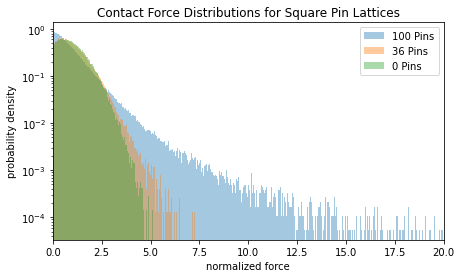

In [ ]:
from scipy import stats
plt.figure(figsize=(7,4))
for file, label in zip(['squ100_07-19','squ36_07-11','non0_07-11'],['100 Pins', '36 Pins', '0 Pins']):
    bw = 2*stats.iqr(dataDict[file]['normalizedForce']/1e6, rng=(25,75), scale=1.0, nan_policy='omit')/(len(dataDict[file])**(1/3))
    plt.hist(dataDict[file]['normalizedForce']/1e6, bins=int((dataDict[file]['normalizedForce'].max()/1e6-dataDict[file]['normalizedForce'].min()/1e6)/bw), density=True, alpha=0.4, label=label)
plt.yscale('log')
#plt.ylim(1e-1,1)
plt.xlim(0,20)
plt.legend()
plt.xlabel('normalized force')
plt.ylabel('probability density')
plt.title('Contact Force Distributions for Square Pin Lattices')
plt.savefig('plots/presentation_forceDistribution.png', dpi=300)

## 3.2. Distributions zeroed to no-pin data

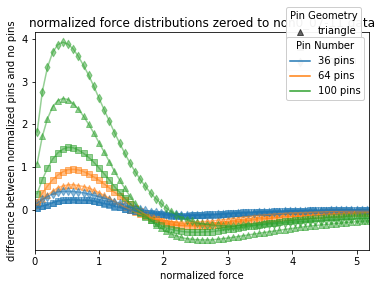

In [ ]:
from matplotlib.lines import Line2D

bw=0.08
bins=np.arange(0,100, bw)
nonHist=dataDict['non0_07-11'].groupby(pd.cut(dataDict['non0_07-11']['normalizedForce']/1e6, bins)).size()
nonHist=nonHist/(nonHist.sum()*bw)

for file in ['tri36_07-11', 'tri64_07-12', 'tri100_07-19','squ36_07-11', 'squ64_07-12', 'squ100_07-19','ran36_07-11', 'ran100_07-19']:
    pinHist=dataDict[file].groupby(pd.cut(dataDict[file]['normalizedForce']/1e6, bins)).size()
    pinHist=pinHist/(pinHist.sum()*bw)
    if file[0:3]=='squ':
        marker='s'
    elif file[0:3]=='tri':
        marker='^'
    elif file[0:3]=='ran':
        marker='d'
    if int(file[3:5])==10:
        color='C2'
    elif int(file[3:5])==36:
        color='C0'
    elif int(file[3:5])==64:
        color='C1'
    plt.scatter(bins[:-1]+np.diff(bins)/2,(pinHist-nonHist).cumsum(), alpha=0.5, marker=marker, color=color)
    plt.plot(bins[:-1]+np.diff(bins)/2,(pinHist-nonHist).cumsum(), alpha=0.5, color=color)
plt.xlim(0,dataDict['non0_07-11']['normalizedForce'].max()/1e6)
plt.ylabel('difference between normalized pins and no pins')
plt.xlabel('normalized force')
plt.title('normalized force distributions zeroed to non0_07-11 data')

plt.scatter([],[], marker='^',c='k', alpha = 0.6, label='triangle')
plt.scatter([],[], marker='s',c='k', alpha = 0.6, label = 'square')
plt.scatter([],[], marker='d',c='k', alpha = 0.6, label='random')

particleLegend1 = plt.gca().legend(loc=(0.75,0.826),title='Pin Geometry',framealpha=0.95)
plt.gca().add_artist(particleLegend1) # matplotlib also overwrites with the latest legend call by default, so we specify we want this one as-is

# Line legend
custom_lines1 = [Line2D([0], [0], color='C0'),
                Line2D([0], [0], color='C1'),
                Line2D([0], [0], color='C2'),]
lineLegend = plt.gca().legend(custom_lines1,['36 pins', '64 pins', '100 pins'],loc='upper right',title='Pin Number',framealpha=0.95)

#plt.savefig('plots/normalized_force_difference-july2020.png', dpi=300)

## 3.3. Power law fits on force tails

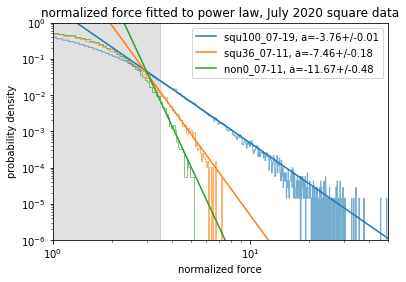

In [ ]:
def power_law(x, c, alpha):
    return c*(x**alpha)

a=[]
pindensity=[]
geometry=[]
bw=0.08
plt.figure(figsize=(6,4))
for counter, file in enumerate(['squ100_07-19','squ36_07-11','non0_07-11']):
    n, bins = plt.hist(dataDict[file]['normalizedForce']/1e6, bins=int(1e-6*dataDict[file]['normalizedForce'].max()/bw), histtype='step', color='C{}'.format(counter), alpha=0.6, density=True)[:2]
    bins=bins[:-1]+np.diff(bins)/2
    parameters, covariance = sp.curve_fit(power_law, bins[bins>4], n[bins>4], maxfev=1000000)
    error=np.sqrt(np.diag(covariance))
    xrange=np.linspace(1e-5,50, 1000)
    a.append(parameters[1])
    geometry.append(file[0:3])
    if file[3:5]=='0_':
        pinnumber=0
    elif int(file[3:5])==10:
        pinnumber=100
    else:
        pinnumber=int(file[3:5])
    pindensity.append(int(pinnumber)/(230+int(pinnumber)))
    plt.ylim(1e-6,1)
    plt.xlim(1,50)
    plt.loglog(xrange, power_law(xrange, parameters[0], parameters[1]), color='C{}'.format(counter), label='{}, a={a:.2f}+/-{ae:.2f}'.format(file, a=parameters[1],ae=error[1]))
    plt.legend()
    #plt.yscale('log')
    plt.axvspan(0,4,alpha=0.04,color='k')
    plt.title('normalized force fitted to power law, July 2020 square data')
    plt.xlabel('normalized force')
    plt.ylabel('probability density')
    plt.savefig('plots/presentation-force_loglog_power_fits-squ.png', dpi=300)
alphaFrame=pd.DataFrame({'pindensity':pindensity,'alpha':a,'geometry':geometry})

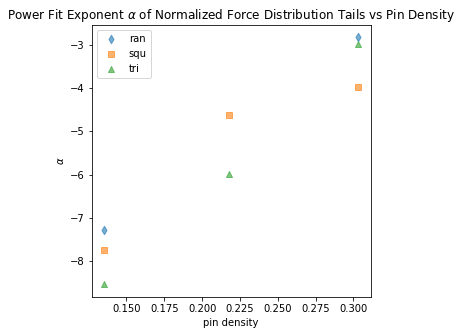

In [ ]:
plt.figure(figsize=(5,5))
for colorCounter, geo in enumerate(alphaFrame.groupby('geometry')):
    if geo[0]=='non':
        marker='X'
    elif geo[0]=='squ':
        marker='s'
    elif geo[0]=='tri':
        marker='^'
    elif geo[0]=='ran':
        marker='d'
    plt.scatter(geo[1]['pindensity'], geo[1]['alpha'],  marker=marker, alpha=0.6, label=geo[0], color='C{}'.format(colorCounter))
plt.ylabel(r'$\alpha$')
plt.xlabel('pin density')
plt.title(r'Power Fit Exponent $\alpha$ of Normalized Force Distribution Tails vs Pin Density')
plt.legend()
plt.savefig('plots/force_distribution_exponents-july2020.png', dpi=300)

## 3.4. Weak force behavior, adjusted for bucklers

AxesSubplot(0.125,0.125;0.227941x0.755) [1.33152557 1.40034159] [1.73011829 1.13527811]
AxesSubplot(0.398529,0.125;0.227941x0.755) [1.56333241 1.44857718] [1.71905095 1.12525111]
AxesSubplot(0.672059,0.125;0.227941x0.755) [1.95771939 1.04768622] [1.93380436 0.81018239]


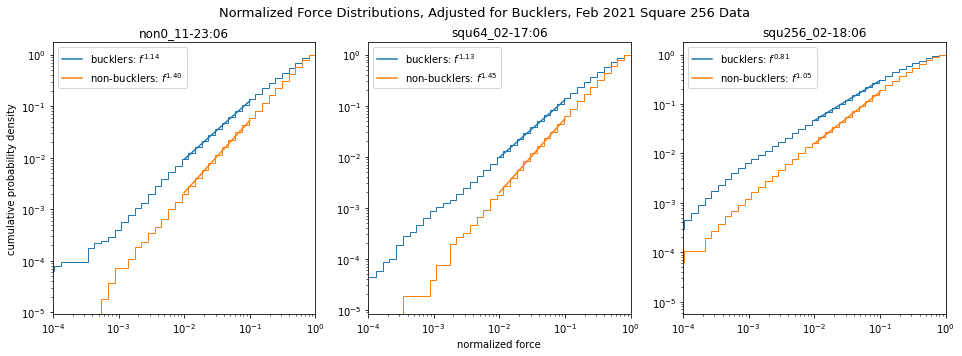

In [ ]:
def power_law(x, c, alpha):
    return c*(x**alpha)

#contactsDict={file:sort_particles(dataDict[file]).groupby(['x','y','trialName']).size().reset_index(name='contacts').set_index(['trialName','x','y']) for file in (files)} # dataframe of particle coordinates, with contact number and trial labeled
cutoff=1
pressureCutoff=1e-2
bw=0.02
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for file, ax in zip(['non0_11-23:06','squ64_02-17:06','squ256_02-18:06'], axes):

    # get data
    bucklers=dataDict[file][['x1','y1','x2','y2','normalizedForce']].copy()
    bucklers=pd.concat([bucklers[['x1','y1','normalizedForce']].rename({'x1':'x','y1':'y'}, axis='columns'),bucklers[['x2','y2','normalizedForce']].rename({'x2':'x','y2':'y'}, axis='columns')])
    # here we end up double-counting each bond, but this is negated by the normalized histogram.

    # filter for 3-contact particles
    bucklers['contacts']=bucklers.groupby(['trialName','x','y'])['normalizedForce'].transform('size')
    bucklers=bucklers[bucklers.contacts==3]['normalizedForce']

    # filter for only weak force bonds
    bucklers=bucklers[bucklers<cutoff*1e6]

    # filter for only low pressure trials
    #pressures=get_pressures(filenames[file])
    #bucklers=bucklers.loc[pressures[pressures<pressureCutoff].index]
    #print(len(pressures[pressures<pressureCutoff].index))

    # get not-bucklers and plot
    #notbucklers=dataDict[file]['normalizedForce'].loc[pressures[pressures<pressureCutoff].index].drop(bucklers.index)
    notbucklers=dataDict[file]['normalizedForce'].drop(bucklers.index)
    n_bucklers = ax.hist(bucklers/1e6, bins=10**np.linspace(-5,0,50), histtype='step', density=True, cumulative=True)[0]
    n_notbucklers, bins = ax.hist(notbucklers[notbucklers<cutoff*1e6]/1e6, bins=10**np.linspace(-5,0,50), histtype='step', density=True, cumulative=True)[:2]
    bins=bins[:-1]+np.diff(bins)/2
    p_notbucklers, cov_notbucklers = sp.curve_fit(power_law, bins[(bins>1e-2)&(bins<1e-1)], n_notbucklers[(bins>1e-2)&(bins<1e-1)], maxfev=1000000)
    p_bucklers, cov_bucklers = sp.curve_fit(power_law, bins[(bins>1e-2)&(bins<1e-1)], n_bucklers[(bins>1e-2)&(bins<1e-1)], maxfev=1000000)
    xrange=np.linspace(1e-2,0.1,1000)
    ax.plot(xrange, power_law(xrange, p_bucklers[0], p_bucklers[1]), color='C0', label=r'bucklers: $f^{%.2f}$' % p_bucklers[1])
    ax.plot(xrange, power_law(xrange, p_notbucklers[0], p_notbucklers[1]), color='C1', label=r'non-bucklers: $f^{%.2f}$' % p_notbucklers[1])
    print(ax, p_notbucklers, p_bucklers)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(file)
    ax.set_xlim(1e-4,1)
    ax.legend(loc='upper left')
axes[0].set_ylabel('cumulative probability density')
axes[1].set_xlabel('normalized force')
fig.suptitle('Normalized Force Distributions, Adjusted for Bucklers, Feb 2021 Square 256 Data', fontsize=13)
plt.savefig('plots/buckler_adjusted-cumulative_force_dist-presentation.jpg', dpi=300)

## 3.5 Loglog Very Weak Force Distributions

In [ ]:
fileGroups = [files[1:4], files[6:]]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
pressureCutoff=1e-2
for fileGroup,ax in zip(fileGroups, axes):

    for file in fileGroup:
        pressures=get_pressures(filenames[file])
        #print(len(pressures[pressures<pressureCutoff].index))
        ax.hist(dataDict[file].loc[pressures[pressures<pressureCutoff].index]['normalizedForce']/1e6, histtype='step', bins=10**np.linspace(-5,0,60), alpha=0.8, linewidth=2, density=False, label=file.split('_')[0])    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-4,1)
    #ax.set_ylim(1e-2, 30)
    ax.set_title(fileGroup[0][0:3])
    ax.legend(loc='upper left')
    ax.set_xlabel('f/<f>')
axes[0].set_ylabel('probability density')
fig.suptitle('Weak Force Distributions Low Pressures, loglog')
#fig.savefig('plots/weakforcedistribution-all_pressure-loglog-July2020.jpg', dpi=300)

## 3.6. Pressure Mean Force Behavior
For no-pin data, pressure should scale linearly with mean force. As the pin density increases it becomes possible to support strong localized force chains which don't translate to the overall pressure of the configuration and the linear fit broadens and pulls upward.

[['non0_07-11', 'squ36_07-11', 'squ64_07-12', 'squ100_07-19'], ['non0_07-11', 'tri36_07-11', 'tri64_07-12', 'tri100_07-19'], ['non0_07-11', 'ran36_07-11', 'ran100_07-19']]


Text(0.5, 0.98, 'mean force vs. pressure')

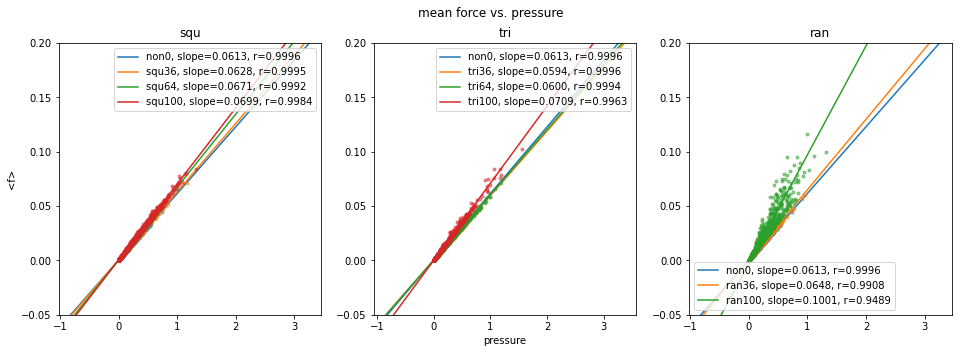

In [ ]:
from scipy import stats

dataDict[files[0]].groupby('trialName')['force'].mean().abs()
get_pressures(filenames[files[0]])

fig, axes = plt.subplots(1,3, figsize=(16,5))
fileGroups = [files[0:4], [files[0]]+files[6:], [files[0]]+files[4:6]]
print(fileGroups)
for fileGroup, ax in zip(fileGroups, axes):
    for colorCounter, file in enumerate(fileGroup):
        meanForces=dataDict[file].groupby('trialName')['force'].mean().abs()
        slope, intercept, r, p, stderr = stats.linregress(meanForces[meanForces<0.2],get_pressures(filenames[file])[meanForces<0.2])
        ax.plot(get_pressures(filenames[file]), meanForces, '.', color='C{}'.format(colorCounter), alpha=0.5)
        ax.plot(slope*np.array([-0.05,0.2])+intercept, [-0.05,0.2], color='C{}'.format(colorCounter), label='{}, slope={m:.4f}, r={err:.4f}'.format(file.split('_')[0],m=1/slope, err=r))
    ax.set_ylim(-0.05,0.2)
    ax.set_title(fileGroup[1][:3])
    ax.legend()
axes[0].set_ylabel('<f>')
axes[1].set_xlabel('pressure')
fig.suptitle('mean force vs. pressure')
#fig.savefig('plots/meanforce_vs_pressure-July2020.jpg', dpi=300)

## 3.7. Mean Force , Peak Normalized Force, and Power Law Exponent
### function of $\lambda$ and $\alpha$  for pressure range $0.05$ to $0.1$

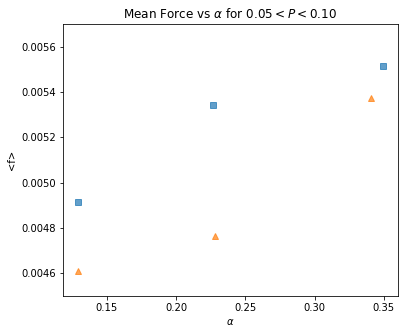

In [ ]:
#finding mean force values in range of pressures
pressureCutoff=(5e-2,1e-1)
lambdaValues=[]
alphaValues=[]
meanForces=[]
geos=[]

for file in files:
    if file[:3]!='non' and file[:3]!='ran':
        fileData=np.array(dataDict[file].index.get_level_values(0)[0].split('-')[2:]).astype('float')
        pressures=get_pressures(filenames[file])
        meanForce=dataDict[file].loc[pressures[(pressures>pressureCutoff[0])&(pressures<pressureCutoff[1])].index]['force'].abs().mean()
        
        meanForces.append(meanForce)
        lambdaValues.append(fileData[-2]/fileData[-1])
        if file[:3]=='tri':
            g=np.sqrt(3)/2
        else:
            g=1
        alphaValues.append(np.pi*(1+1.4**2)/(2*g)*(fileData[-2]/fileData[-1])**2)
        geos.append(dataDict[file].index.get_level_values(0)[0].split('-')[0])

plt.figure(figsize=(6,5))
for geo in pd.DataFrame({'lambda':lambdaValues,'alpha':alphaValues,'meanForce':meanForces,'geometry':geos}).groupby('geometry'):
    if geo[0]=='squ':
        marker='s'
    elif geo[0]=='tri':
        marker='^'
    
    plt.plot(geo[1]['alpha'], geo[1]['meanForce'], marker, alpha=0.7)
plt.ylim(4.5e-3,5.7e-3)
plt.title(r'Mean Force vs $\alpha$ for $%.2f<P<%.2f$' %pressureCutoff)
plt.ylabel('<f>')
plt.xlabel(r'$\alpha$')
#plt.savefig('plots/meanforce_vs_alpha-medpressure-July2020.jpg', dpi=300)

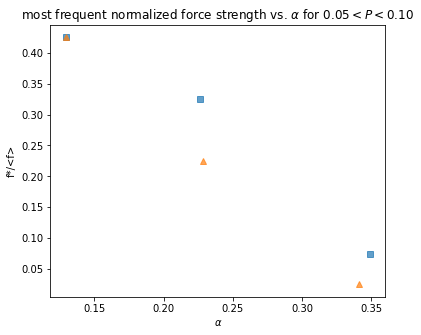

In [ ]:
#peak normalized force, same pressure range (0.05,0.10)
pressureCutoff=(5e-2,1e-1)
bw=0.05
bins=np.arange(0,2,bw)
lambdaValues=[]
alphaValues=[]
peakForces=[]
geos=[]
plt.figure(figsize=(10,6))
colorCounter=0
for file in files:
    if file[:3]!='non' and file[:3]!='ran':
        fileData=np.array(dataDict[file].index.get_level_values(0)[0].split('-')[2:]).astype('float')
        pressures=get_pressures(filenames[file])
        filteredForce=dataDict[file].loc[pressures[(pressures>pressureCutoff[0])&(pressures<pressureCutoff[1])].index]['normalizedForce']/1e6
        peakForce=filteredForce.groupby(pd.cut(filteredForce, bins)).size()/(len(filteredForce)*bw)
        xValues=[iv.mid for iv in peakForce.index.values]
        plt.plot(xValues, peakForce, color='C{}'.format(colorCounter), alpha=0.5)
        #plt.hist(filteredForce, bins=bins, color='C{}'.format(colorCounter), density=True, alpha=0.5, histtype='step')
        plt.scatter(peakForce.idxmax().mid, peakForce.max(), color='C{}'.format(colorCounter), label=file.split('_')[0])
        peakForces.append(peakForce.idxmax().mid)
        lambdaValues.append(fileData[-2]/fileData[-1])
        if file[:3]=='tri':
            g=np.sqrt(3)/2
        else:
            g=1
        alphaValues.append(np.pi*(1+1.4**2)/(2*g)*(fileData[-2]/fileData[-1])**2)
        geos.append(dataDict[file].index.get_level_values(0)[0].split('-')[0])
        colorCounter+=1
plt.yscale('log')
plt.title('normalized force distributions for $%.2f<P<%.2f$' %pressureCutoff)
plt.xlabel('$<f>$')
plt.ylabel('probability density')
plt.legend()
#plt.savefig('plots/forcedistributions-withpeaks-medpressure.jpg', dpi=300)
plt.close()

plt.figure(figsize=(6,5))
for geo in pd.DataFrame({'lambda':lambdaValues,'alpha':alphaValues,'peak':peakForces,'geometry':geos}).groupby('geometry'):
    if geo[0]=='squ':
        marker='s'
    elif geo[0]=='tri':
        marker='^'
    
    plt.plot(geo[1]['alpha'], geo[1]['peak'], marker, alpha=0.7)
plt.title(r'most frequent normalized force strength vs. $\alpha$ for $%.2f<P<%.2f$' %pressureCutoff)
plt.ylabel('f*/<f>')
plt.xlabel(r'$\alpha$')
#plt.savefig('plots/peakforce_vs_alpha-medpressure-July2020.jpg', dpi=300)

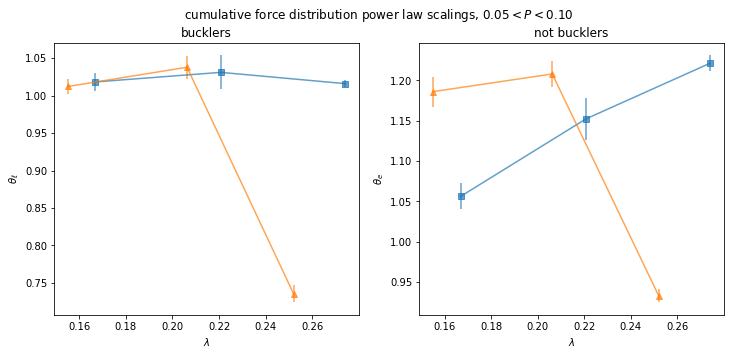

In [ ]:
# buckler power scalings

def power_law(x, c, alpha):
    return c*(x**alpha)

buckler_powers=[]
notbuckler_powers=[]
buckler_err=[]
notbuckler_err=[]
lambdaValues=[]
geos=[]

pressureCutoff=(5e-2,1e-1)
cutoff=1
for file in files:
    if file[:3]!='non' and file[:3]!='ran':
        fileData=np.array(dataDict[file].index.get_level_values(0)[0].split('-')[2:]).astype('float')
        # get data
        bucklers=dataDict[file][['x1','y1','x2','y2','normalizedForce']].copy()
        bucklers=pd.concat([bucklers[['x1','y1','normalizedForce']].rename({'x1':'x','y1':'y'}, axis='columns'),bucklers[['x2','y2','normalizedForce']].rename({'x2':'x','y2':'y'}, axis='columns')])
        # here we end up double-counting each bond, but this is negated by the normalized histogram.

        # filter for 3-contact particles
        bucklers['contacts']=bucklers.groupby(['trialName','x','y'])['normalizedForce'].transform('size')
        bucklers=bucklers[bucklers.contacts==3]['normalizedForce']

        # filter for only weak force bonds
        bucklers=bucklers[bucklers<cutoff*1e6]

        # filter for only medium-pressure trials
        pressures=get_pressures(filenames[file])
        bucklers=bucklers.loc[pressures[(pressures>pressureCutoff[0])&(pressures<pressureCutoff[1])].index]

        # get not-bucklers and curve fit
        notbucklers=dataDict[file]['normalizedForce'].loc[pressures[(pressures>pressureCutoff[0])&(pressures<pressureCutoff[1])].index].drop(bucklers.index)
        n_bucklers = plt.hist(bucklers/1e6, bins=10**np.linspace(-5,0,50), histtype='step', density=True, cumulative=True)[0]
        n_notbucklers, bins = plt.hist(notbucklers[notbucklers<cutoff*1e6]/1e6, bins=10**np.linspace(-5,0,50), histtype='step', density=True, cumulative=True)[:2]
        bins=bins[:-1]+np.diff(bins)/2
        p_notbucklers, cov_notbucklers = sp.curve_fit(power_law, bins[(bins>1e-2)&(bins<1e-1)], n_notbucklers[(bins>1e-2)&(bins<1e-1)], maxfev=1000000)
        p_bucklers, cov_bucklers = sp.curve_fit(power_law, bins[(bins>1e-2)&(bins<1e-1)], n_bucklers[(bins>1e-2)&(bins<1e-1)], maxfev=1000000)

        buckler_powers.append(p_bucklers[-1])
        notbuckler_powers.append(p_notbucklers[-1])
        buckler_err.append(np.sqrt(np.diag(cov_bucklers))[-1])
        notbuckler_err.append(np.sqrt(np.diag(cov_notbucklers))[-1])
        lambdaValues.append(fileData[-2]/fileData[-1])
        if file[:3]=='tri':
            g=np.sqrt(3/2)
        else:
            g=1
        alphaValues.append(np.pi*(1+1.4**2)/(2*g)*(fileData[-2]/fileData[-1])**2)
        geos.append(dataDict[file].index.get_level_values(0)[0].split('-')[0])
plt.close()

fig, [ax_bucklers,ax_notbucklers]=plt.subplots(1,2,figsize=(12,5))
for geo in pd.DataFrame({'lambda':lambdaValues,'alpha':alphaValues,'bucklers':buckler_powers,'buckler_err':buckler_err,'notbucklers':notbuckler_powers,'notbuckler_err':notbuckler_err,'geometry':geos}).groupby('geometry'):
    if geo[0]=='squ':
        marker='s'
    elif geo[0]=='tri':
        marker='^'
    
    ax_bucklers.errorbar(geo[1]['lambda'], geo[1]['bucklers'], yerr=geo[1]['buckler_err'], marker=marker, alpha=0.7)
    ax_notbucklers.errorbar(geo[1]['lambda'], geo[1]['notbucklers'], yerr=geo[1]['notbuckler_err'], marker=marker, alpha=0.7)
fig.suptitle('cumulative force distribution power law scalings, $%.2f<P<%.2f$' %pressureCutoff)
ax_bucklers.set_title('bucklers')
ax_notbucklers.set_title('not bucklers')
ax_bucklers.set_ylabel(r'$\theta_\ell$')
ax_notbucklers.set_ylabel(r'$\theta_e$')
ax_bucklers.set_xlabel(r'$\lambda$')
ax_notbucklers.set_xlabel(r'$\lambda$')
#fig.savefig('plots/cumulativePowers_vs_lambda-medpressure-July2020.jpg', dpi=300)

In [ ]:
dataDict[file]['force']

trialName                   rowNumber
non-70000-512-0-0.0190-.10  0           -1.625480e-08
                            1           -1.038970e-08
                            2           -3.045080e-09
                            3           -1.251700e-08
                            4           -3.510830e-08
                                             ...     
non-70200-512-0-0.0190-.10  194823      -3.804960e-08
                            194824      -9.207620e-08
                            194825      -3.554260e-08
                            194826      -1.086320e-08
                            194827      -3.608200e-08
Name: force, Length: 194828, dtype: float32

## 3.8 Fitting Force Distributions to Gaussian

Turns out all our old exponential fits were wrong, because the way we're normalizing forces we should really be comparing to a Gaussian! So here are the proper fits for data.

If we normalize the force _per trial,_ so each configuration has its mean force set to 1, the distribution should look like a Gaussian. If we normalize the force to the mean force _for an entire large dataset_, the distribution should look like a decaying exponential.

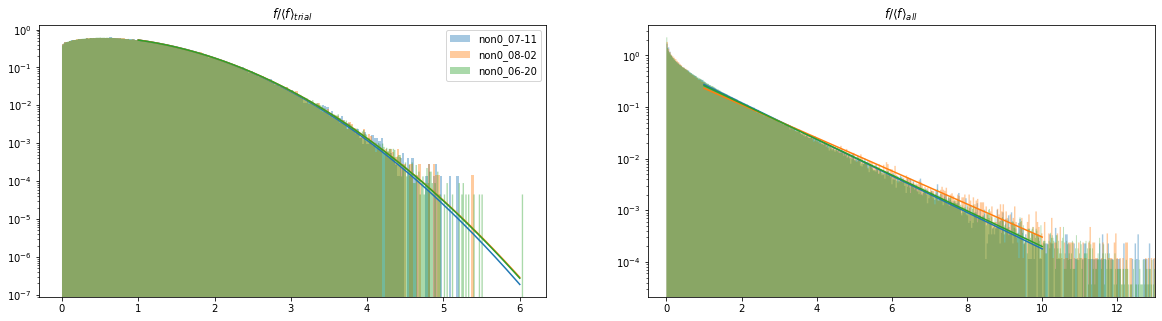

In [ ]:
from scipy import stats
def Gaussian(x, mean, std, coeff):
    return coeff/np.sqrt(2*np.pi*std**2)*np.exp(-(x-mean)**2/(2*std**2))
def Linear(x, slope, intercept):
    return slope*x+intercept


fig, [axGaussian, axExp] = plt.subplots(1, 2, figsize=(20,5))
axGaussian.set_yscale('log')
axExp.set_yscale('log')
for colorCounter, file in enumerate(['non0_07-11', 'non0_08-02', 'non0_06-20']):
    bwGauss = 2*stats.iqr(dataDict[file]['normalizedForce']/1e6, rng=(25,75), scale=1.0, nan_policy='omit')/(len(dataDict[file])**(1/3))
    nGauss, binsGauss = axGaussian.hist(dataDict[file]['normalizedForce']/1e6, bins=int((dataDict[file]['normalizedForce'].max()/1e6-dataDict[file]['normalizedForce'].min()/1e6)/bwGauss), density=True, alpha=0.4, histtype='stepfilled', label=file, color='C{}'.format(colorCounter))[:2]
    binsGauss=binsGauss[:-1]+np.diff(binsGauss)/2
    [GaussMean, GaussSTD, coeff], GaussCov = sp.curve_fit(Gaussian, binsGauss[binsGauss>1], nGauss[binsGauss>1])
    xValues=np.linspace(1,6,1000)
    GaussValues=Gaussian(xValues, GaussMean, GaussSTD, coeff)
    axGaussian.plot(xValues, GaussValues, color='C{}'.format(colorCounter))
    bwExp = 2*stats.iqr(dataDict[file]['force']/dataDict[file]['force'].mean(), rng=(25,75), scale=1.0, nan_policy='omit')/(len(dataDict[file])**(1/3))
    nExp, binsExp = axExp.hist(dataDict[file]['force']/dataDict[file]['force'].mean(), bins=int(((dataDict[file]['force']/dataDict[file]['force'].mean()).max()-(dataDict[file]['force']/dataDict[file]['force'].mean()).min())/bwExp), density=True, histtype='stepfilled', alpha=0.4, label=file, color='C{}'.format(colorCounter))[:2]
    binsExp=binsExp[:-1]+np.diff(binsExp)/2
    [ExpSlope, ExpIntercept], ExpCov = sp.curve_fit(Linear, binsExp[(binsExp>1)&(binsExp<9)], np.log(nExp[(binsExp>1)&(binsExp<9)]))
    xValues=np.linspace(1,10,1000)
    ExpValues=np.exp(Linear(xValues, ExpSlope, ExpIntercept))
    axExp.plot(xValues, ExpValues, color='C{}'.format(colorCounter))

axExp.set_xlim(-0.5, 13)
axGaussian.set_title(r'$f/\langle f\rangle_{trial}$')
axExp.set_title(r'$f/\langle f\rangle_{all}$')
axGaussian.legend()
#plt.savefig('Force Fits.jpg', dpi=300)


# 4. Analysis of Weak Particle-Pin "Scaffolding" Contacts

## 4.1 Weak particle-pin bar plots

In [0]:
contactsDict={file:sort_particles(dataDict[file]).groupby(['x','y','trialName']).size().reset_index(name='contacts') for file in (files)} # dataframe of particle coordinates, with contact number and trial labeled
for file in files:
    contactsDict[file].set_index(['trialName','x','y'], inplace=True)
    weakPins=dataDict[file][(dataDict[file].bondType>=3)&(dataDict[file].normalizedForce<=5e3)][['x1','y1','x2','y2','normalizedForce']].copy()
    weakPins['contactsParticle']=weakPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x2'],x['y2']]['contacts'], axis=1)
    weakPins['contactsPin']=weakPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x1'],x['y1']]['contacts'], axis=1)
    allPins=dataDict[file][(dataDict[file].bondType>=3)][['x1','y1','x2','y2','normalizedForce']].copy()
    allPins['contactsParticle']=allPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x2'],x['y2']]['contacts'], axis=1)
    allPins['contactsPin']=allPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x1'],x['y1']]['contacts'], axis=1)
    fig, (axAll, axWeak) = plt.subplots(1,2, figsize=(12,4))
    for ax, data in [(axAll, allPins), (axWeak, weakPins)]:
        ax.hist(data['contactsParticle'],bins=np.linspace(2.5,7.5,6), density=True, label='particle contacts')
        ax.hist(data['contactsPin'],bins=np.linspace(0.5,2.5,3), density=True, label = 'pin contacts')
        ax.set_ylim(0,0.9)
        ax.set_axisbelow(True)
        ax.grid(linestyle='dashed')
        ax.set_xlabel('number of contacts')
    axWeak.set_title('weak contacts, normalized force < 0.005')
    axAll.set_title('all contacts')
    axWeak.legend()
    fig.subplots_adjust(top=0.85)
    plt.suptitle('normalized distribution of particle/pin contacts, {}'.format(file), fontsize=14, x=0.52)
    #plt.savefig('plots/particlePinContactNumbers/particle_pin_contact_distribution-{}.png'.format(file),dpi=300)
    plt.show()

## 4.2. Aggregated weak particle-pin bar plots

In [0]:
allDF = []
weakDF = []
for file in files:
    contactsDict={file:sort_particles(dataDict[file]).groupby(['x','y','trialName']).size().reset_index(name='contacts') for file in (files)} # dataframe of particle coordinates, with contact number and trial labeled
    contactsDict[file].set_index(['trialName','x','y'], inplace=True)
    weakPins=dataDict[file][(dataDict[file].bondType>=3)&(dataDict[file].normalizedForce<=5e-3)][['x1','y1','x2','y2','normalizedForce']].copy()
    weakPins['contactsParticle']=weakPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x2'],x['y2']]['contacts'], axis=1)
    weakPins['contactsPin']=weakPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x1'],x['y1']]['contacts'], axis=1)
    allPins=dataDict[file][(dataDict[file].bondType>=3)][['x1','y1','x2','y2','normalizedForce']].copy()
    allPins['contactsParticle']=allPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x2'],x['y2']]['contacts'], axis=1)
    allPins['contactsPin']=allPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x1'],x['y1']]['contacts'], axis=1)
    allDF = pd.append(allPins[['contactsParticle', 'contactsPin']])
    weakDF = pd.append(weakDF,weakPins[['contactsParticle','contactsPin']])

In [0]:
fig, (axAll, axWeak) = plt.subplots(1,2, figsize=(12,4))
for ax, data in [(axAll, allDF), (axWeak, weakDF)]:
    ax.hist(data['contactsParticle'],bins=np.linspace(2.5,7.5,6), density=True, label='particle contacts')
    ax.hist(data['contactsPin'],bins=np.linspace(0.5,2.5,3), density=True, label = 'pin contacts')
    ax.set_ylim(0,0.9)
    ax.set_axisbelow(True)
    ax.grid(linestyle='dashed')
    ax.set_xlabel('number of contacts')
axWeak.set_title('weak contacts, normalized force < 0.005')
axAll.set_title('all contacts')
axWeak.legend()
fig.subplots_adjust(top=0.85)
plt.suptitle('normalized distribution of particle/pin contacts, aggregated', fontsize=14, x=0.52)
#plt.savefig('plots/particlePinContactNumbers/particle_pin_contact_distribution-aggregate.png',dpi=300)
#plt.close()

## 4.3. Bar plots animated for varying force thresholds

In [ ]:
contactsDict={file:sort_particles(dataDict[file]).groupby(['x','y','trialName']).size().reset_index(name='contacts').set_index(['trialName','x','y']) for file in (files)} # dataframe of particle coordinates, with contact number and trial labeled
plot=False
cutoffs=0.5**np.linspace(-2,10,20)
weakPinList = []
for file in files:
    #if file[:3]!='non':
    for cutoff in cutoffs:
        #weakPins=dataDict[file][(dataDict[file].bondType>=3)&(dataDict[file].normalizedForce<=cutoff*1e6)][['x1','y1','x2','y2','normalizedForce']].copy()
        weakPins=dataDict[file][(dataDict[file].normalizedForce<=cutoff*1e6)][['x1','y1','x2','y2','normalizedForce']].copy()

        contactsParticle=contactsDict[file].loc[weakPins.reset_index().set_index(['trialName','x2','y2']).index]['contacts']
        contactsPin=contactsDict[file].loc[weakPins.reset_index().set_index(['trialName','x1','y1']).index]['contacts']
        allContacts=pd.concat([contactsPin[contactsPin>2], contactsParticle[contactsParticle>2]])
        weakPinList.append({'file':file, 'cutoff':cutoff,
                                    'avgParticle':allContacts.mean(),'particleErr':allContacts.sem()})
        #weakPinList.append({'file':file, 'cutoff':cutoff,
        #                            'avgParticle':contactsParticle.mean(),'particleErr':contactsParticle.sem(),
        #                            'avgPin':contactsPin.mean(),'pinErr':contactsPin.sem()})
        if plot:
            fig, axWeak = plt.subplots(1,1, figsize=(10,6))
            axWeak.hist(contactsParticle,bins=np.linspace(2.5,7.5,6), density=True, label='particle contact numbers')
            axWeak.hist(contactsPin,bins=np.linspace(0.5,2.5,3), density=True, label = 'pin contact numbers')
            axWeak.set_ylim(0,0.9)
            axWeak.set_axisbelow(True)
            axWeak.grid(linestyle='dashed')
            axWeak.set_xlabel('number of contacts')
            axWeak.set_title('normalized force < {c:.3f}'.format(c=cutoff))
            axWeak.legend()
            fig.subplots_adjust(top=0.9)
            plt.suptitle('constituent contact numbers for particle-pin contacts, {}'.format(file), fontsize=14, x=0.52)
            plt.savefig('plots/bucklers/{}_cutoff-{}.png'.format(file, cutoff),dpi=300)
            plt.show()

weakPinDF = pd.concat([pd.DataFrame(df, index=[0]) for df in weakPinList]).sort_values('cutoff').dropna()

In [0]:
import imageio
from glob import glob

image_list=[]
for imagename in sorted(glob('plots/bucklers/*.png'), reverse=True): # get all .pngs in the directory
    image_list.append(imageio.imread(imagename))
imageio.mimwrite('plots/bucklers/bucklers_animated-{}-.gif'.format(file), image_list, duration = 0.3)

## 4.4. Average scaffolding contact number vs. force threshold

[ 16  36  49  64 100]


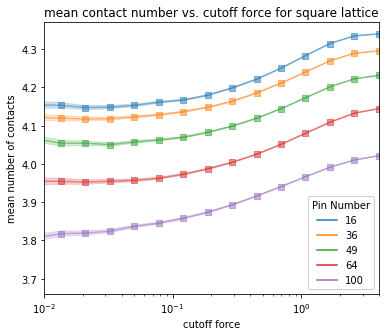

In [ ]:
from matplotlib.lines import Line2D
pin_densities = np.unique([int(file.split('_')[0][3:]) for file in files])
print(pin_densities)
counter=0
plt.figure(figsize=(6,5))
for fileDF in weakPinDF.groupby('file'):
    if True:
        color = 'C{}'.format(np.where(pin_densities==int(fileDF[0].split('_')[0][3:]))[0][0])
        if fileDF[0][0:3]=='squ':
            marker='s'
        elif fileDF[0][0:3]=='tri':
            marker='^'
        elif fileDF[0][0:3]=='ran':
            marker='X'
        elif fileDF[0][0:3]=='non':
            print(fileDF[0])
            marker='d'
            counter+=1
            color = 'C{}'.format(counter)
        plt.scatter(fileDF[1]['cutoff'],fileDF[1]['avgParticle'], alpha=0.5, marker=marker, color=color)
        plt.plot(fileDF[1]['cutoff'],fileDF[1]['avgParticle'], color=color, alpha=0.5)
        plt.fill_between(fileDF[1]['cutoff'],y1=fileDF[1]['avgParticle']+fileDF[1]['particleErr'],y2=fileDF[1]['avgParticle']-fileDF[1]['particleErr'], color=color, alpha=0.2)

plt.title('mean contact number vs. cutoff force for square lattice')
plt.ylabel('mean number of contacts')
plt.xlabel('cutoff force')

#plt.scatter([],[], marker='^',c='k', alpha = 0.6, label='triangle')
#plt.scatter([],[], marker='s',c='k', alpha = 0.6, label = 'square')
#plt.scatter([],[], marker='X',c='k', alpha = 0.6, label='random')

#PinLegend1 = plt.gca().legend(loc=(0.75,0.826),title='Pin Geometry',framealpha=0.95)
#plt.gca().add_artist(PinLegend1) # matplotlib also overwrites with the latest legend call by default, so we specify we want this one as-is

# Line legend
custom_lines1 = [Line2D([0], [0], color='C0'),
                Line2D([0], [0], color='C1'),
                Line2D([0], [0], color='C2'),
                Line2D([0], [0], color='C3'),
                Line2D([0], [0], color='C4')]
lineLegend = plt.gca().legend(custom_lines1,['16', '36', '49', '64','100'],loc='lower right',title = 'Pin Number',framealpha=0.95)
plt.xscale('log')
plt.xlim(1e-2, 4)
plt.ylim(3.66,4.37)

plt.savefig('plots/presentation-scaffolding_particle_z_vs_cutoff.png', dpi=300)

## 4.5. Percentage of weak contacts which are scaffolding

In [ ]:
contactsDict={file:sort_particles(dataDict[file]).groupby(['x','y','trialName']).size().reset_index(name='contacts').set_index(['trialName','x','y']) for file in (files)} # dataframe of particle coordinates, with contact number and trial labeled
cutoffs=0.5**np.linspace(-1,10,20)
threeBondDF=pd.DataFrame(columns=['file','cutoff','percentAll','percentPins'])
for file in files:
    for cutoff in cutoffs:
        if file[:4] != 'non0':
            weakParticles=pd.concat([contactsDict[file].sort_index(),
                                        sort_particles(dataDict[file][(dataDict[file].normalizedForce<=cutoff*1e6)]).groupby(['trialName','x','y','particleType']).size().reset_index().set_index(['trialName','x','y'])['particleType']],axis=1,join='inner')
            weakPins=dataDict[file][(dataDict[file].bondType>=3)&(dataDict[file].normalizedForce<=cutoff*1e6)][['x2','y2']].copy()
            weakPins=weakParticles.loc[weakPins.rename(columns=lambda x: x[0]).reset_index().set_index(['trialName','x','y']).index]
            weakPins=weakPins[weakPins.contacts==3]
            threeBondDF=threeBondDF.append({'file':file, 'cutoff':cutoff,'percentAll':len(weakParticles[weakParticles.contacts==3].index)/len(weakParticles.index), 'percentPins':len(weakPins.index)/len(weakParticles.index)}, ignore_index=True)

threeBondDF.set_index(['file','cutoff'], inplace=True)

In [ ]:
contactsDict={file:sort_particles(dataDict[file]).groupby(['x','y','trialName']).size().reset_index(name='contacts').set_index(['trialName','x','y']) for file in (files)} # dataframe of particle coordinates, with contact number and trial labeled
cutoffs=0.5**np.linspace(-1,10,20)
threeBondDF=pd.DataFrame(columns=['file','cutoff','percentAll'])
for file in files:
    print(file)
    for cutoff in cutoffs:
        weakParticles=pd.concat([contactsDict[file].sort_index(), sort_particles(dataDict[file][(dataDict[file].normalizedForce<=cutoff*1e6)]).groupby(['trialName','x','y']).size().reset_index().set_index(['trialName','x','y'])],axis=1,join='inner')
        #weakParticles=sort_particles(dataDict[file][(dataDict[file].normalizedForce<=cutoff*1e6)]).groupby(['trialName','x','y']).size().reset_index().set_index(['trialName','x','y'])
        threeBondDF=threeBondDF.append({'file':file, 'cutoff':cutoff,'percentAll':len(weakParticles[weakParticles['contacts']==3].index)/len(weakParticles.index)}, ignore_index=True)

non0_07-11
squ36_07-11
squ64_07-12
squ100_07-19
ran36_07-11
ran100_07-19
tri36_07-11
tri64_07-12
tri100_07-19


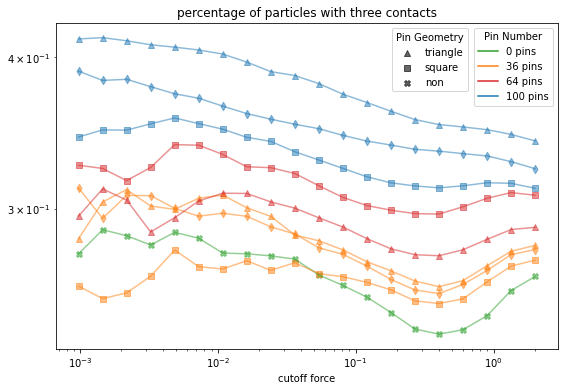

In [ ]:
from matplotlib.lines import Line2D
fig = plt.figure(figsize=(9,6))
axAll = fig.add_subplot()
for fileDF in threeBondDF.groupby('file'):
    if fileDF[0][0:3]=='squ':
        marker='s'
    elif fileDF[0][0:3]=='tri':
        marker='^'
    elif fileDF[0][0:3]=='non':
        marker='X'
    elif fileDF[0][0:3]=='ran':
        marker='d'
    if int(fileDF[0].split('_')[0][3:])==0:
        color = 'C2'
    elif int(fileDF[0][3:5])==10:
        color='C0'
    elif int(fileDF[0][3:5])==36:
        color='C1'
    elif int(fileDF[0][3:5])==64:
        color='C3'
    axAll.scatter(fileDF[1]['cutoff'],fileDF[1]['percentAll'], alpha=0.5, marker=marker, color=color)
    axAll.loglog(fileDF[1]['cutoff'],fileDF[1]['percentAll'], color=color, alpha=0.5)
axAll.set_title('percentage of particles with three contacts')
axAll.set_xlabel('cutoff force')

plt.scatter([],[], marker='^',c='k', alpha = 0.6, label='triangle')
plt.scatter([],[], marker='s',c='k', alpha = 0.6, label = 'square')
plt.scatter([],[], marker='X',c='k', alpha = 0.6, label='non')

PinLegend1 = axAll.legend(title='Pin Geometry', loc=(0.67,0.79))
axAll.add_artist(PinLegend1) # matplotlib also overwrites with the latest legend call by default, so we specify we want this one as-is

# Line legend
custom_lines1 = [Line2D([0], [0], color='C2'),
                Line2D([0], [0], color='C1'),
                Line2D([0], [0], color='C3'),
                Line2D([0], [0], color='C0'),]
lineLegend = axAll.legend(custom_lines1,['0 pins','36 pins', '64 pins', '100 pins'],title='Pin Number')

#plt.xscale('log')
#plt.title('scaffolding pin influence as cutoff force decreases', fontsize=14)
#fig.tight_layout()

plt.savefig('plots/scaffolding_threebond_vs_cutoff-july2020.png', dpi=300)

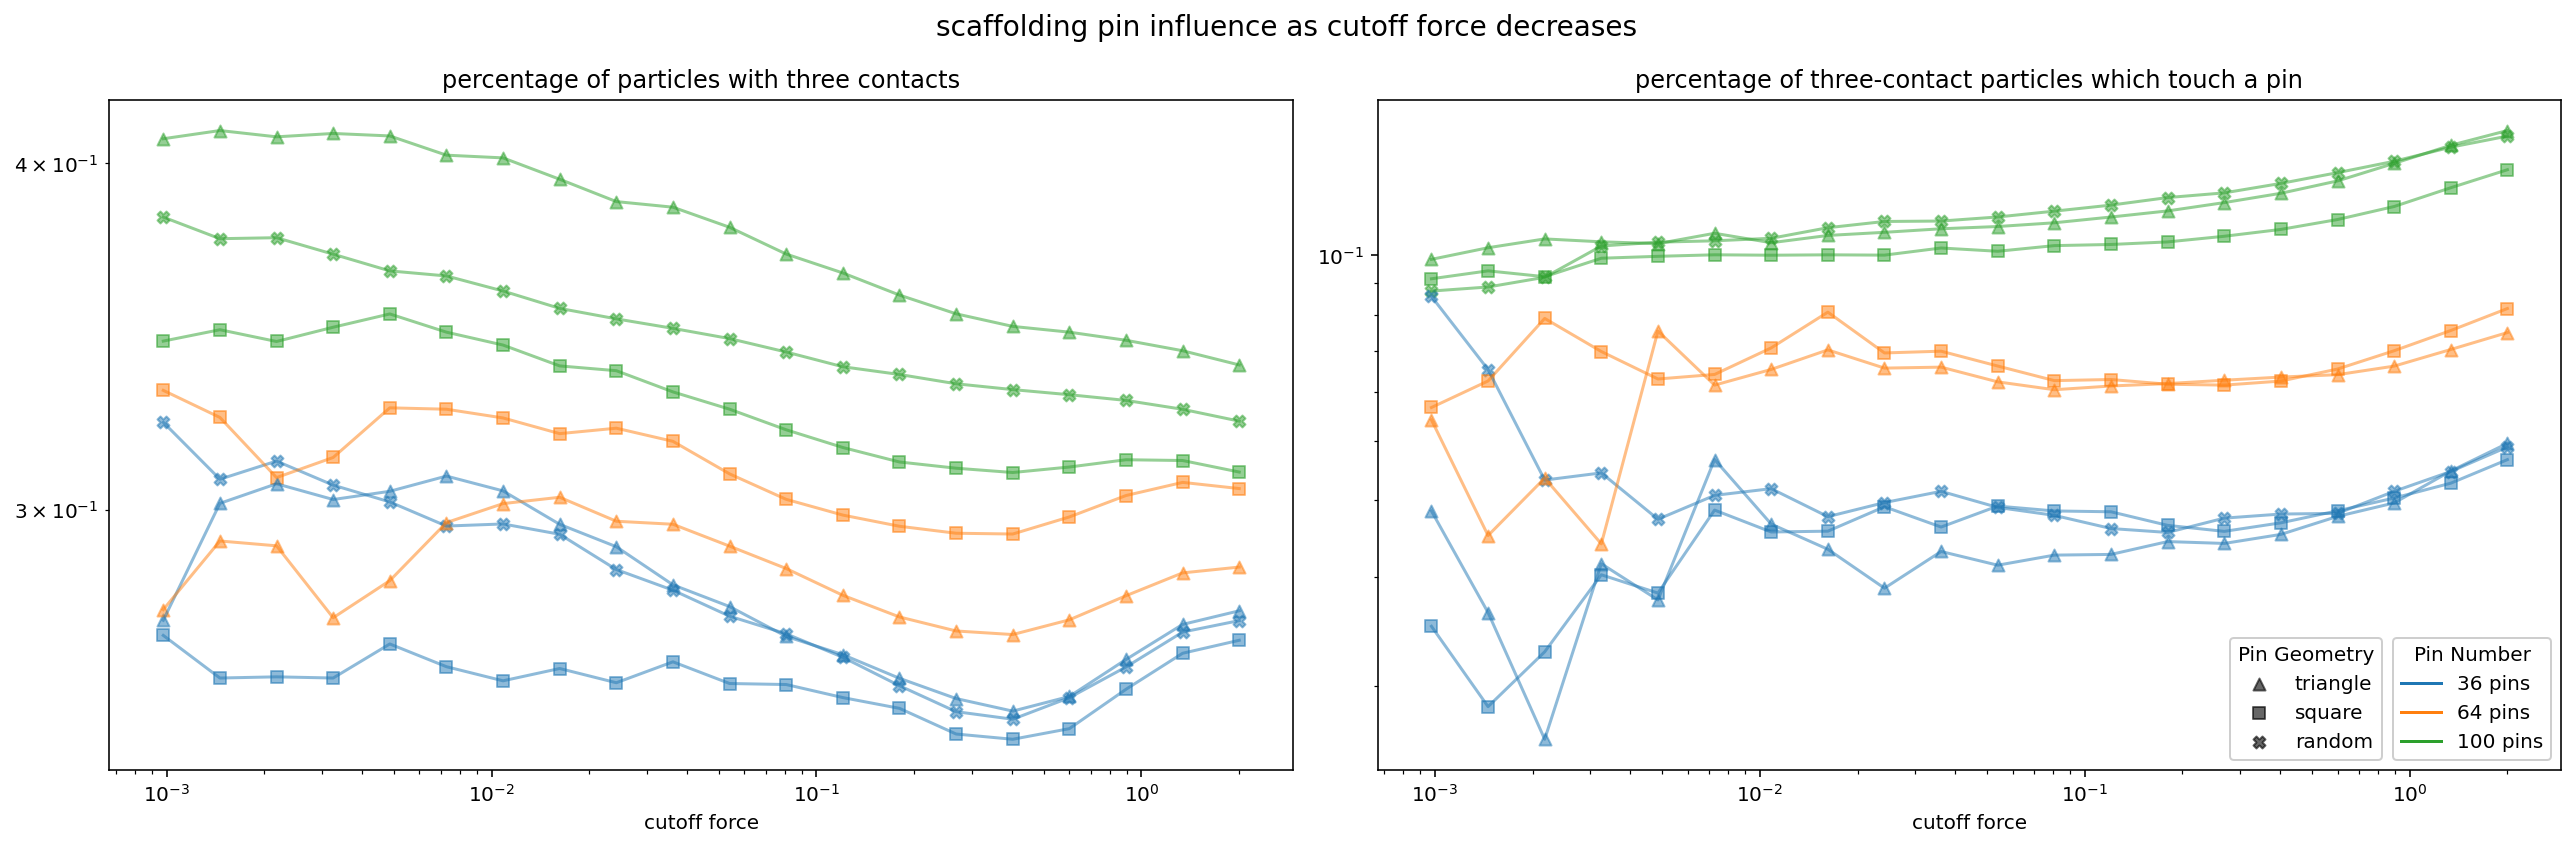

In [ ]:
fig, [axAll,axPins]=plt.subplots(1,2, figsize=(18,6))
for fileDF in threeBondDF.groupby('file'):
    if fileDF[0][0:3]=='squ':
        marker='s'
    elif fileDF[0][0:3]=='tri':
        marker='^'
    elif fileDF[0][0:3]=='non':
        marker='X'
    if int(fileDF[0][3:5])==10:
        color='C2'
    elif int(fileDF[0][3:5])==36:
        color='C0'
    elif int(fileDF[0][3:5])==64:
        color='C1'
    axAll.scatter(fileDF[1].index.get_level_values(1),fileDF[1]['percentAll'], alpha=0.5, marker=marker, color=color)
    axAll.loglog(fileDF[1].index.get_level_values(1),fileDF[1]['percentAll'], color=color, alpha=0.5)
    axPins.scatter(fileDF[1].index.get_level_values(1),fileDF[1]['percentPins']/fileDF[1]['percentAll'], alpha=0.5, marker=marker, color=color)
    axPins.loglog(fileDF[1].index.get_level_values(1),fileDF[1]['percentPins']/fileDF[1]['percentAll'], color=color, alpha=0.5)
axAll.set_title('percentage of particles with three contacts')
axPins.set_title('percentage of three-contact particles which touch a pin')
axAll.set_xlabel('cutoff force')
axPins.set_xlabel('cutoff force')

plt.scatter([],[], marker='^',c='k', alpha = 0.6, label='triangle')
plt.scatter([],[], marker='s',c='k', alpha = 0.6, label = 'square')
plt.scatter([],[], marker='X',c='k', alpha = 0.6, label='random')

PinLegend1 = axPins.legend(loc=(0.72,0.015),title='Pin Geometry',framealpha=0.95)
axPins.add_artist(PinLegend1) # matplotlib also overwrites with the latest legend call by default, so we specify we want this one as-is

# Line legend
custom_lines1 = [Line2D([0], [0], color='C0'),
                Line2D([0], [0], color='C1'),
                Line2D([0], [0], color='C2'),]
lineLegend = axPins.legend(custom_lines1,['36 pins', '64 pins', '100 pins'],loc='lower right',title='Pin Number',framealpha=0.95)

plt.xscale('log')
fig.suptitle('scaffolding pin influence as cutoff force decreases', fontsize=14)
fig.tight_layout()

#plt.savefig('plots/scaffolding_threebond_vs_cutoff-july2020.png', dpi=300)

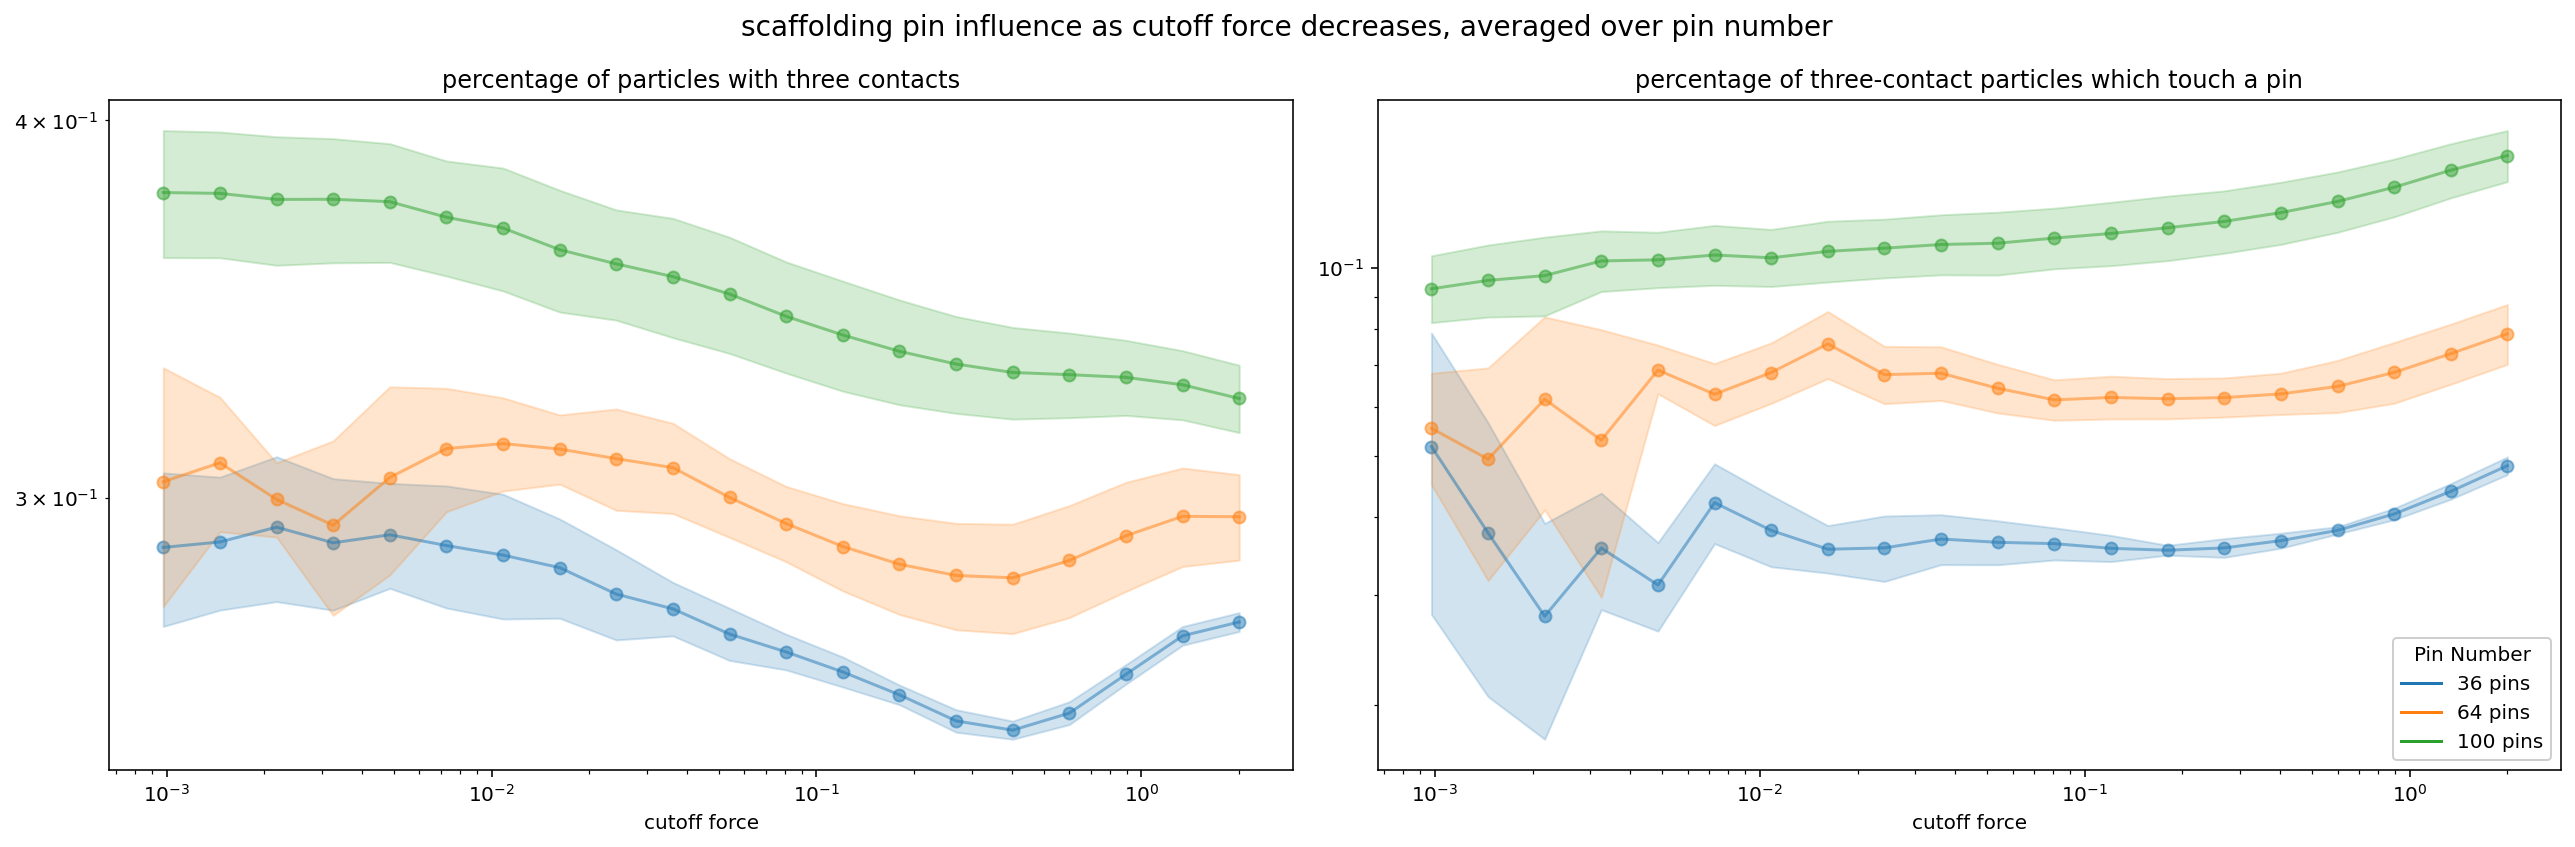

In [ ]:
fig, [axAll,axPins]=plt.subplots(1,2, figsize=(18,6))
pinGroups=[['tri36_07-11','squ36_07-11','ran36_07-11'],['tri64_07-12','squ64_07-12'],['tri100_07-19','squ100_07-19','ran100_07-19']]
for colorCounter, pinGroup in enumerate(pinGroups):
    avgDF=threeBondDF.loc[pinGroup].groupby('cutoff').agg(['mean','sem'])
    axAll.scatter(avgDF.index.values,avgDF['percentAll','mean'], alpha=0.5, color='C{}'.format(colorCounter))
    axAll.loglog(avgDF.index.values,avgDF['percentAll','mean'], color='C{}'.format(colorCounter), alpha=0.5)
    axAll.fill_between(avgDF.index.values,y1=avgDF['percentAll','mean']+avgDF['percentAll','sem'],y2=avgDF['percentAll','mean']-avgDF['percentAll','sem'], color='C{}'.format(colorCounter), alpha=0.2)
    axPins.scatter(avgDF.index.values,avgDF['percentPins','mean']/avgDF['percentAll','mean'], alpha=0.5, color='C{}'.format(colorCounter))
    axPins.loglog(avgDF.index.values,avgDF['percentPins','mean']/avgDF['percentAll','mean'], color='C{}'.format(colorCounter), alpha=0.5)
    axPins.fill_between(avgDF.index.values,y1=(avgDF['percentPins','mean']+avgDF['percentPins','sem'])/(avgDF['percentAll','mean']-avgDF['percentAll','sem']),y2=(avgDF['percentPins','mean']-avgDF['percentPins','sem'])/(avgDF['percentAll','mean']+avgDF['percentAll','sem']), color='C{}'.format(colorCounter), alpha=0.2)
axAll.set_title('percentage of particles with three contacts')
axPins.set_title('percentage of three-contact particles which touch a pin')
axAll.set_xlabel('cutoff force')
axPins.set_xlabel('cutoff force')
fig.suptitle('scaffolding pin influence as cutoff force decreases, averaged over pin number', fontsize=14)

# Line legend
custom_lines1 = [Line2D([0], [0], color='C0'),
                Line2D([0], [0], color='C1'),
                Line2D([0], [0], color='C2'),]
lineLegend = axPins.legend(custom_lines1,['36 pins', '64 pins', '100 pins'],loc='lower right',title='Pin Number',framealpha=0.95)
fig.tight_layout()

#plt.savefig('plots/scaffolding_threebond_vs_cutoff_mean-july2020.png', dpi=300)

# 5. Visualizing Force Topography with Heat Maps

Average Force per Bin for Square 64 Data


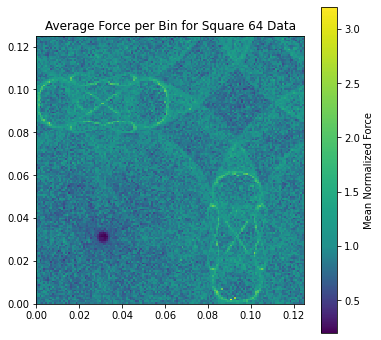

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6), subplot_kw={'aspect':1})
plot_heatmap('squ64_08-05', ax, mapType='force', title='Average Force per Bin for Square 64 Data', show=True, bondTypes=[0,1,2])
#plt.savefig('plots/presentation_square64_forces.jpg', dpi=300)

## 5.1. Heatmap Plotting Function

In [ ]:
from scipy.stats import binned_statistic_2d
import matplotlib
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def plot_heatmap(file, heatmapax, mapType='force', force_range=[0,1], title='Default', show=True, cmap=False, scale=False, mod=True, resolution=150, bondTypes=range(5)):
    bondInfo=dataDict[file].copy()
    [geo,num_particles,num_pins,r_small,pin_separation]=[bondInfo.index.get_level_values('trialName')[0].split('-')[x] for x in [0,2,3,4,5]]
    num_particles=int(num_particles)
    num_pins=int(num_pins)
    r_small=float(r_small)
    pin_separation=float(pin_separation)
    bondInfo[['x1','y1','x2','y2','normalizedForce']]=bondInfo[['x1','y1','x2','y2','normalizedForce']]*1e-6
    
    # find pins
    #print('\t finding pins:')
    allPinsInFile=sort_particles(bondInfo,types=[0]) # pull all pin rows
    pinMin=allPinsInFile.min()
    pinMax=allPinsInFile.max()

    # filter for specified force percentile
    bondInfo=bondInfo[(bondInfo.normalizedForce<bondInfo.normalizedForce.quantile(force_range[1]))&(bondInfo.normalizedForce>bondInfo.normalizedForce.quantile(force_range[0]))]
    
    if mapType=='angle':
        colormap='twilight'
        bondInfo=pd.concat([bondInfo, get_angles(filenames[file])], axis=1)
    else:
        colormap='viridis'
    #print('pin separation:', pin_separation)
    if cmap:
        colormap = cmap

    BLAS_list = []
    for bondType in bondTypes:
        #print('\t bond locations for bondType', bondGroup[0])
        BLAS_list.append(bond_location(bondInfo[bondInfo['bondType']==bondType], bondType))
    bond_locations_and_strengths = pd.concat(BLAS_list, axis=0)


    if mod:
        bond_locations_and_strengths['x']%=pin_separation
        bond_locations_and_strengths['y']%=pin_separation
        span=(0,pin_separation,0,pin_separation)
        bins=np.linspace(0,pin_separation,resolution)

    else:
        span=(0,1,0,1)
        bins=np.linspace(0,1, resolution)

    #if file[:3]=='tri':
    #    #span = (0,1.5,-0.1,np.sqrt(3)/2+0.1)
    #    pinMin['x']-=pinMin['y']*np.tan(np.pi/6)
    #    pinMax['x']-=pinMax['y']*np.tan(np.pi/6)
    #    
    #    bond_locations_and_strengths['x']-=bond_locations_and_strengths['y']*np.tan(np.pi/6)
    #    bond_locations_and_strengths['y']+=bond_locations_and_strengths['y']*np.tan(np.pi/6)*np.tan(np.pi/12)

    if mod:
        pinGrid=[pinMin['x'],pinMin['x']]
    else:
        pinGrid=np.meshgrid(np.linspace(pinMin['x'],pinMax['x'],int(np.sqrt(num_pins))),np.linspace(pinMin['x'],pinMax['x'],int(np.sqrt(num_pins))))

    #if file[:3]=='tri':
    #    pinGrid[0]+=pinGrid[1]*np.sin(np.pi/6)
    #    pinGrid[1]-=pinGrid[1]*np.sin(np.pi/6)*np.tan(np.pi/12)

    # bin and average bonds
    #print('\t binning and averaging:')
    if force_range[0]!=0:
        lowerbound=', force > {l:.3f}'.format(l=bondInfo.normalizedForce.quantile(force_range[0]))
    else:
        lowerbound=''
    if force_range[1]!=1:
        upperbound=', force < {u:.3f}'.format(u=bondInfo.normalizedForce.quantile(force_range[1]))
    else:
        upperbound=''

    if mapType=='force':
        meanForces=binned_statistic_2d(bond_locations_and_strengths['x'], bond_locations_and_strengths['y'], bond_locations_and_strengths['force'], statistic=np.mean, bins=[bins,bins])
        heatmap = heatmapax.imshow(meanForces.statistic.T, origin='lower', interpolation='none', norm=MidpointNormalize(midpoint=1, vmin=meanForces[0][~np.isnan(meanForces[0])].flatten().min(), vmax=meanForces[0][~np.isnan(meanForces[0])].flatten().max()), extent=span, cmap=colormap)
        colorbar_label='Mean Normalized Force'
    elif mapType=='angle':
        meanAngle=binned_statistic_2d(bond_locations_and_strengths['x'], bond_locations_and_strengths['y'], bond_locations_and_strengths['angle'], statistic=np.mean, bins=[bins,bins])
        heatmap = heatmapax.imshow(meanAngle.statistic.T, origin='lower', norm=MidpointNormalize(midpoint=1, vmin=meanAngle[0][~np.isnan(meanAngle[0])].flatten().min(), vmax=meanAngle[0][~np.isnan(meanAngle[0])].flatten().max()), extent=span, cmap=colormap)
        colorbar_label='Mean Angle'
    elif mapType=='counts':
        heatmap = heatmapax.hist2d(bond_locations_and_strengths['x'], bond_locations_and_strengths['y'], bins=[resolution,resolution], norm=colors.LogNorm(), cmap=colormap)[3]
        colorbar_label='number of contacts'

    if scale:
        heatmapax.plot([pinMin['x'], pinMin['x']+r_small*2], [pinMin['y'], pinMin['y']], ':', color='red', linewidth=2, label='small diameter')
        heatmapax.plot([pinMin['x'], pinMin['x']+(r_small*2.8)/np.sqrt(2)], [pinMin['y'], pinMin['y']+(r_small*2.8)/np.sqrt(2)], '--', color='red', linewidth=2, label='large diameter')
        heatmapax.legend()
    #heatmapax.plot(pinGrid[0],pinGrid[1], 'o', mec='black', mfc='white')
    plt.colorbar(heatmap, ax=heatmapax, orientation='vertical', label=colorbar_label)

    # cosmetics & export
    print(title+lowerbound+upperbound)
    heatmapax.set_title(title+lowerbound+upperbound)

In [ ]:
for mapType in ['counts']:#['angle', 'force', 'counts']:
    for file in ['squ64_08-05']:
        fig, [[ax1,ax2], [ax3, ax4]] = plt.subplots(2,2,subplot_kw={'aspect':1},figsize=(8,8))
        plot_heatmap(file, ax1, mapType = mapType, force_range=[0.95,1],mod=True, title='all particle-particle bonds'.format(file), bondTypes=[0,1,2])
        plot_heatmap(file, ax2, mapType = mapType, force_range=[0.95,1],mod=True, title='small-small'.format(file), bondTypes=[0])
        plot_heatmap(file, ax4, mapType = mapType, force_range=[0.95,1],mod=True, title='small-large'.format(file), bondTypes=[1])
        plot_heatmap(file, ax3, mapType = mapType, force_range=[0.95,1],mod=True, title='large-large'.format(file), bondTypes=[2])
        plt.suptitle('average bond {} by location, {}'.format(mapType, file), y=0.98)
        fig.tight_layout()
        plt.savefig('plots/{file}-heatmap-{type}.jpg'.format(type=mapType, file=file), dpi=300)
        plt.show()
        plt.close()

locations of 90th percentile strong forces,
squ64_08-05 large-large, force > 4.280


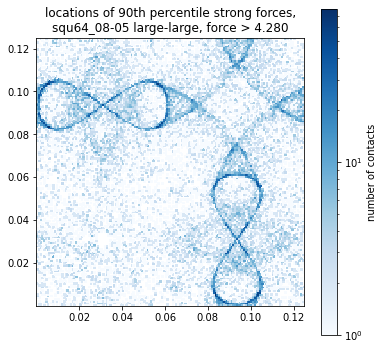

In [ ]:
for file in ['squ64_08-05']:
    fig, ax = plt.subplots(1,1, subplot_kw={'aspect':1}, figsize=(6,6))
    plot_heatmap(file, ax,mapType = 'counts', force_range=[0.90,1], bondTypes=[2], title = 'locations of 90th percentile strong forces,\n{} large-large'.format(file))
    plt.savefig('plots/presentation-{file}-StrongForceHist_90-LargeLarge.jpg'.format(file=file), dpi=300)
    plt.show()
    plt.close()
#bondInfo[bondInfo.normalizedForce>bondInfo.normalizedForce.quantile(0.99)]

Histogram of Contacts for Square 64 Data


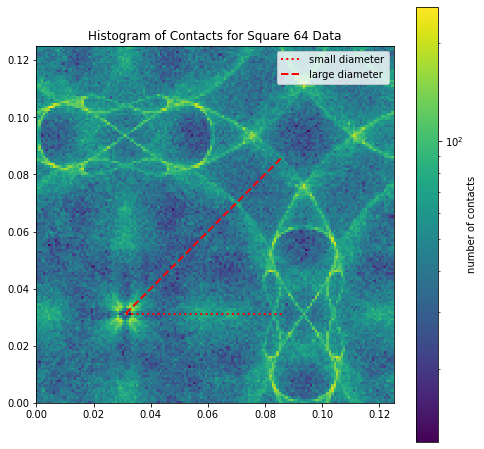

In [ ]:
fig, ax = plt.subplots(1,1, subplot_kw={'aspect':'equal'}, figsize=(8,8))
plot_heatmap('squ64_08-05', ax, title='Histogram of Contacts for Square 64 Data', bondTypes=[0,1,2], mapType='counts', scale=True)

## 5.2 Bond angle distributions at uniform distance from pin

In [ ]:
from scipy import stats
def angle_dist(file, axes, radius, show=True, resolution=150, bondTypes=range(5)):
    bondInfo=dataDict[file].copy()
    [geo,num_particles,num_pins,r_small,pin_separation]=[bondInfo.index.get_level_values('trialName')[0].split('-')[x] for x in [0,2,3,4,5]]
    num_particles=int(num_particles)
    num_pins=int(num_pins)
    r_small=float(r_small)
    pin_separation=float(pin_separation)
    bondInfo[['x1','y1','x2','y2','normalizedForce']]=bondInfo[['x1','y1','x2','y2','normalizedForce']]*1e-6
    bondInfo=pd.concat([bondInfo, get_angles(filenames[file])], axis=1)
    #bondInfo=bondInfo[bondInfo.normalizedForce>bondInfo.normalizedForce.quantile(0.99)]

    #print('pin separation:', pin_separation)

    BLAS_list = []
    for bondType in bondTypes:
        #print('\t bond locations for bondType', bondGroup[0])
        BLAS_list.append(bond_location(bondInfo[bondInfo['bondType']==bondType], bondType))
    bond_locations_and_strengths = pd.concat(BLAS_list, axis=0)

    allPinsInFile=sort_particles(bondInfo,types=[0]) # pull all pin rows
    pinMin=allPinsInFile.min()
    pinMax=allPinsInFile.max()

    span=(0,pin_separation,0,pin_separation)
    bins=np.linspace(0,pin_separation,resolution)

    pinGrid=[pinMin['x'],pinMin['x']]

    bond_locations_and_strengths['x']-=pinMin['x']
    bond_locations_and_strengths['y']-=pinMin['y']

    bond_locations_and_strengths['x']=(bond_locations_and_strengths['x']+pin_separation/2)%pin_separation-pin_separation/2
    bond_locations_and_strengths['y']=(bond_locations_and_strengths['y']+pin_separation/2)%pin_separation-pin_separation/2
    
    bond_locations_and_strengths['r']=np.sqrt(bond_locations_and_strengths['x']**2+bond_locations_and_strengths['y']**2)
    bond_locations_and_strengths['theta']=np.arctan(bond_locations_and_strengths['y']/bond_locations_and_strengths['x'])
    bond_locations_and_strengths['angle_centered']=(bond_locations_and_strengths['angle']+(np.pi/2-bond_locations_and_strengths['theta']))%np.pi
    
    heatmap = axes[0].hist2d(bond_locations_and_strengths['x'], bond_locations_and_strengths['y'], bins=[resolution,resolution], norm=colors.LogNorm(), cmap='viridis')[3]
    plt.colorbar(heatmap, ax=axes[0], orientation='vertical', label='number of counts')
    bond_locations_and_strengths=bond_locations_and_strengths[(bond_locations_and_strengths.r>radius[0])&(bond_locations_and_strengths.r<radius[1])]
    #bw = 2*stats.iqr(bond_locations_and_strengths['angle_centered'], rng=(25,75), scale=1.0, nan_policy='omit')/(len(bond_locations_and_strengths)**(1/3)) # Freedman-Diaconis rule for histogram bin width
    #print(bw)
    #num_bins=int(np.pi/bw)
    num_bins=50
    axes[1].hist(bond_locations_and_strengths['angle_centered'], bins=num_bins, density=True, alpha=0.8, label=file)
    axes[1].grid(b=None, axis='y')
    plt.xlim(0,np.pi)
    axes[0].add_patch(plt.Circle((0,0), radius[0], facecolor='none', edgecolor='r'))
    axes[0].add_patch(plt.Circle((0,0), radius[1], facecolor='none', edgecolor='r'))
    axes[0].set_title('histogram of bond locations, {}'.format(file))
    axes[1].set_title('angles of bonds with respect to radial direction\n{r_low:.3f} to {r_high:.3f} from pin, N={N}'.format(r_low=radius[0],r_high=radius[1],N=len(bond_locations_and_strengths)), y=0.82)

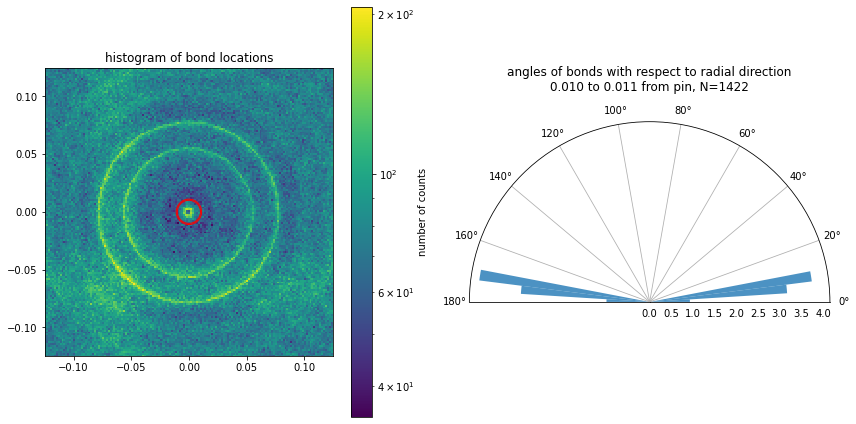

In [ ]:
fig=plt.figure(figsize=(12,6))
axHist = fig.add_subplot(121, aspect=1)
axAngle = fig.add_subplot(122, projection='polar')
angle_dist(file, [axHist,axAngle], [0.01,0.011], bondTypes=[0,1,2])
fig.tight_layout()

In [ ]:
file='squ16_08-05'
counter=26
for radius in np.linspace(0.026,0.125,100):
    counter+=1
    print(counter)
    fig=plt.figure(figsize=(12,6))
    axHist = fig.add_subplot(121, aspect=1)
    axAngle = fig.add_subplot(122, projection='polar')
    angle_dist(file, [axHist,axAngle], [radius,radius+0.001], bondTypes=[0,1,2])
    fig.tight_layout()
    if not os.path.exists('plots/2-19/Angle_Dist/{}'.format(file)):
        os.makedirs('plots/2-19/Angle_Dist/{}'.format(file))
    plt.savefig('plots/2-19/Angle_Dist/{file}/{file}-angle_dist-{counter:03}.jpg'.format(file=file,counter=counter))
    plt.close()

In [ ]:
#!pip install imageio
import imageio
from glob import glob

with imageio.get_writer('plots/2-19/Angle_Dist/squ16_08-05/squ16-angle_dist.gif', mode='I', duration=1/10) as writer:
    for filename in sorted(glob('plots/2-19/Angle_Dist/squ16_08-05/*.jpg')):
        image = imageio.imread(filename)
        writer.append_data(image)

## 5.3 Solving geometric constraints for figure-eights

In [ ]:
def solve_f8_constraint(r1, r2, a, theta):
    # law of cosines
    l = np.sqrt((r1*np.sin(theta))**2+(a-r1*np.cos(theta))**2)
    alpha=np.arcsin(r1/l*np.sin(theta))
    phi=np.arccos(((r1+r2)**2-r2**2-l**2)/(-2*r2*l))
    # output point coordinates
    x0 = 0
    x1 = r1*np.cos(theta)
    x3_up = a-r2*np.cos(alpha+phi)
    x2_up = x1+r1/(r1+r2)*(x3_up-x1)
    x3_down = a-r2*np.cos(alpha-phi)
    x2_down = x1+r1/(r1+r2)*(x3_down-x1)
    x4 = a

    x_up = np.array([x0,x1,x2_up,x3_up,x4])
    x_down =np.array([x0,x1,x2_down,x3_down,x4])

    y0 = 0
    y1 = r1*np.sin(theta)
    y3_up = r2*np.sin(alpha+phi)
    y2_up = y1+r1/(r1+r2)*(y3_up-y1)
    y3_down = r2*np.sin(alpha-phi)
    y2_down = y1+r1/(r1+r2)*(y3_down-y1)
    y4 = 0

    y_up = np.array([y0,y1,y2_up,y3_up,y4])
    y_down = np.array([y0,y1,y2_down,y3_down,y4])

    return x_up, y_up, x_down, y_down

In [ ]:
from matplotlib import collections
r1=0.0276*1.4
r2=0.0276*1.4
a=0.142857142857
counter=0
interfaceX=[]
interfaceY=[]

length_colormap = 400
#for theta in np.linspace(-np.pi,np.pi, 800):
for theta in [0]:
    x1, y1, x2, y2 = solve_f8_constraint(r1,r2,a,theta)
    if np.isnan(x1).any():
        continue
    else:
        counter+=1
        fig, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'aspect':1})
        ax.add_patch(plt.Circle((x1[1],y1[1]), r1, alpha=0.5))
        ax.add_patch(plt.Circle((x1[3],y1[3]), r2, alpha=0.5))
        #ax.add_patch(plt.Circle((x2[3],y2[3]), r2, alpha=0.5))
        interfaceX+=[x1[2], x2[2]]
        interfaceY+=[y1[2],y2[2]]
        #ax.add_collection(collections.LineCollection(zip([interfaceX, interfaceY]),linewidths=0.5))#, colors=np.linspace(0,1,length_colormap)[:counter]))
        #plt.plot(x1,y1)
        #plt.plot(x2,y2)
        #plt.plot([0,a, x1[1], x1[3], x2[3]], [0,0, y1[1],y1[3],y2[3]],'o', color='k')
        plt.plot([0,a], [0,0],'o', color='k')
        #plt.plot([x1[2], x2[2]], [y1[2],y2[2]],'o')
        plt.xlim(-r1, a+r1)
        plt.ylim(-2*r1,2*r1)
        plt.title('figure eights for squ100 large-large interactions')
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        
        plt.savefig('plots/presentation_largelarge.jpg'.format(counter), dpi=300)
        #plt.show()
        plt.close()

In [ ]:
#!pip install imageio
import imageio
from glob import glob

with imageio.get_writer('plots/2-19/geoConstraint-squ100_largesmall.gif', mode='I', duration=1/60) as writer:
    for filename in sorted(glob('plots/2-19/geoConstraint/squ100_largesmall/*.jpg')):
        image = imageio.imread(filename)
        writer.append_data(image)

# 6. Visualizing individual trials

## 6.1. Topography Plotting Function
The plot_topography function takes a DataFrame and name of a trial and plots it. This primarily consists of preparing BondInfo data for plotting, which entails sorting particles by type, accounting for bonds which wrap at the boundary, and if the data is of a triangular lattice, applying a transformation before and after the other steps to make it compatible with our square lattice process.

This is necessary as our triangle lattice data is provided with rhombus rather than square boundaries, so we need to pivot the data $30^\circ$ to the left with respect to the x-axis to transform it into a square, account for wrapping, then pivot it back.

Note that pins are drawn disproportionately large for reference, and since we're only given the small particle radius, the large radius is found by scaling the small radius up by a factor of 1.4. If this relation varies, we will need more information.

In [ ]:
from matplotlib import collections
from matplotlib.lines import Line2D

# What's really important: picking a fun color scheme
#colormap = matplotlib.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 'r', '#FFFFFF', '#FFFFFF']) # classic
colormap = matplotlib.cycler('color',['#FAD55C','#68C182','#267DB3','#ED6647','#8561C8','#000000', '#fef9e6', '#c0dff2']) # blue-yellow
plt.rc('axes',prop_cycle=colormap)

def plot_topography(file, trialName, savefig=False, title='Default', particles=True, pins=True, bonds=True, show=True, cutoff=None, sheared=True, interfaces=False):
    # PARAMETERS:
    # file (str) - abbreviated file name, as specified list of files in first cell
    # trialName (str or int) - full trial name, e.g. 'ran-90440-266-36-0.02781-.16667', or integer index of a certain trial
    # savefig (bool/str) - If True, saves to plots folder. If string, saves to specified path.
    # title (str) - name for figure, if not default.
    # particles (bool) - whether or not to show particles.
    # pins (str) - if "all", attempts to extrapolate the entire pin lattice from existing pins. If False, pins are not shown. Otherwise, plots only contacted pins.
    # show (bool) - whether or not display the figure in output.
    # cutoff (float) - value at which to filter out forces. If positive, only show forces greater than the magnitude, and if negative, only show forces less than the magnitude.
    # sheared (bool) - only significant for triangular lattices: if False, plots the data as a square instead ofa rhombus.
    # interfaces (bool) - whether or not to highlight particle points of contact.

    if isinstance(trialName,int):
        trialName=dataDict[file].index.get_level_values('trialName').unique()[trialName]

    bondInfo=dataDict[file].loc[trialName].copy() # get the data
    #find the mean force before filtering out bonds weaker than the cutoff
    meanForce=bondInfo.force.abs().mean()
    if cutoff:
        if cutoff>0:
            bondInfo=bondInfo[bondInfo.normalizedForce>=np.abs(cutoff)]
        elif cutoff<0:
            bondInfo=bondInfo[bondInfo.normalizedForce<=np.abs(cutoff)]

    bondInfo['bondColor']=bondInfo['bondType'].transform(lambda x: 'C'+str(x)) # takes bondtypes and transforms them into color codes

    headerNames=['geometry','seed','num','pins','small_radius','pin_separation']
    trialInfo={}
    for key, label in zip(headerNames,trialName.split('-')):
        trialInfo[key]=label

    # MAKING COORDINATE DATA USEFUL
    all_particles = sort_particles(bondInfo)[['x','y','particleType']].drop_duplicates() # get dataframe of particle coordinates sorted by bond type
    all_particles[['x','y']]=all_particles[['x','y']]*1e-6
    bondInfo[['x1','y1','x2','y2','normalizedForce']]=bondInfo[['x1','y1','x2','y2','normalizedForce']]*1e-6
    if trialInfo['geometry']=='tri': # extra steps for triangular lattice of pins
        # Un-shear the data, so that we can apply the same wrapping algorithm as in the square
        # unshearing matrix: [[1, -tan(30)],[0,1+tan(30)*tan(15)]] (in degrees)
        for x,y in [('x1','y1'),('x2','y2')]: # apply transformation to both sets of coordinate columns
            bondInfo[x]=bondInfo[x]-bondInfo[y]*np.tan(np.pi/6)
            bondInfo[y]=bondInfo[y]*(1+np.tan(np.pi/6)*np.tan(np.pi/12))

        if sheared==False: # normally we don't transform the particles at all, but if we want an unsheared plot we need to unshear the particles as well
            all_particles['x']-=all_particles['y']*np.tan(np.pi/6)
            all_particles['y']+=all_particles['y']*np.tan(np.pi/6)*np.tan(np.pi/12)
    
    # Find wrapping contacts - bonds that are too long not to be wrapping
    # (this is not memory efficient, but individual trials are small enough that we don't care)
    wrapsX=bondInfo[np.abs(bondInfo.x1-bondInfo.x2)>=0.5].copy() # 0.5 is kind of arbitrary here, all that matters is distance > (R_A+R_B)
    wrapsY=bondInfo[np.abs(bondInfo.y1-bondInfo.y2)>=0.5].copy()
    internalBonds=bondInfo.drop(pd.concat([wrapsX,wrapsY]).index.values) # dataframe of non-wrapped contacts

    # Wrapping algorithm: depending on which axis we're wrapping around, signs will flip - this value gives 1 or -1 for each wrapped contact according to sign convention
    wrapsY['yAdjust']=round(wrapsY['y1']-wrapsY['y2'])
    wrapsX['xAdjust']=round(wrapsX['x1']-wrapsX['x2'])

    # Additional case for when bonds wrap through three regions via corner
    wrapsCorner=pd.merge(wrapsX,wrapsY) # dataframe of contacts which wrap on X and Y, with both xAdjust and yAdjust included (corner cases have two sign conventions)
    cornerIndex=wrapsX.index.intersection(wrapsY.index) # TODO: probably a more optimal way to do this, since we're effectively checking for duplicates twice on this line and the previous.

    # Separate corner cases from edge cases (they'll plot differently)
    wrapsX=wrapsX.drop(cornerIndex)
    wrapsY=wrapsY.drop(cornerIndex)

    # Reformat data for LineCollection plotting - TODO: optimize
    # Internal lines
    sourcePoints=np.array([internalBonds['x1'],internalBonds['y1']]).T.reshape(-1,1,2)
    targetPoints=np.array([internalBonds['x2'],internalBonds['y2']]).T.reshape(-1,1,2)
    internalsegments=np.concatenate([sourcePoints,targetPoints],axis=1)

    # X-wrapped lines
    # don't love the repetitive .values calls here, but in 1- or 0- length cases this preserves the shape of the array
    sourcePoints=np.array([wrapsX['x1'].values-wrapsX['xAdjust'].values,wrapsX['y1'].values])
    targetPoints=np.array([wrapsX['x2'].values,wrapsX['y2'].values])
    sourcePoints=np.concatenate([sourcePoints,np.array([wrapsX['x1'].values,wrapsX['y1'].values])]).T.reshape(-1,1,2)
    targetPoints=np.concatenate([targetPoints,np.array([wrapsX['x2'].values+wrapsX['xAdjust'].values,wrapsX['y2'].values])]).T.reshape(-1,1,2)
    xsegments=np.concatenate([sourcePoints,targetPoints],axis=1)

    # Y-wrapped lines
    sourcePoints=np.array([wrapsY['x1'].values,wrapsY['y1'].values-wrapsY['yAdjust'].values])
    targetPoints=np.array([wrapsY['x2'].values,wrapsY['y2'].values])
    sourcePoints=np.concatenate([sourcePoints,np.array([wrapsY['x1'].values,wrapsY['y1'].values])]).T.reshape(-1,1,2)
    targetPoints=np.concatenate([targetPoints,np.array([wrapsY['x2'].values,wrapsY['y2'].values+wrapsY['yAdjust'].values])]).T.reshape(-1,1,2)
    ysegments=np.concatenate([sourcePoints,targetPoints],axis=1)

    # Corner-wrapped lines
    sourcePoints=np.array([]).reshape(-1,1,2)
    targetPoints=np.array([]).reshape(-1,1,2)
    for i in [0,1]: # 2x2 loop (one run for each corner)
        for j in [0,1]:
            sourcePoints=np.concatenate([sourcePoints,np.array([wrapsCorner['x1'].values+wrapsCorner['xAdjust'].values*(i-1),
                                                                wrapsCorner['y1'].values+wrapsCorner['yAdjust'].values*(j-1)]).T.reshape(-1,1,2)])
            targetPoints=np.concatenate([targetPoints,np.array([wrapsCorner['x2'].values+wrapsCorner['xAdjust'].values*(i),
                                                                wrapsCorner['y2'].values+wrapsCorner['yAdjust'].values*(j)]).T.reshape(-1,1,2)])
    cornersegments=np.concatenate([sourcePoints,targetPoints],axis=1)

    if trialInfo['geometry']=='tri' and sheared==True:
        # re-shear the data
        # shearing matrix is [[1,sin(30)],[0,1-sin(30)*tan(15)]] (in degrees)
        for segmentgroup in [internalsegments,xsegments,ysegments,cornersegments]: # bad form to iterate like this, but like above the arrays are small enough to get away with it
            for segment in segmentgroup:
                for point in segment:
                    point[0]+=point[1]*np.sin(np.pi/6)
                    point[1]-=point[1]*np.sin(np.pi/6)*np.tan(np.pi/12)

    # Initialize patch collections
    # lines are plotted with thickness normalizedForce+1 to scale with bond strength while all being visible
    internalLines=collections.LineCollection(internalsegments,linewidths=internalBonds['normalizedForce']+1,color=internalBonds['bondColor'])
    xLines=collections.LineCollection(xsegments,linewidths=wrapsX['normalizedForce'].repeat(2)+1,color=wrapsX['bondColor'].repeat(2))
    yLines=collections.LineCollection(ysegments,linewidths=wrapsY['normalizedForce'].repeat(2),color=wrapsY['bondColor'].repeat(2))
    cornerLines=collections.LineCollection(cornersegments,linewidths=wrapsCorner['normalizedForce'].repeat(4),color=wrapsCorner['bondColor'].repeat(4))

    particleList=[]
    if particles:
        particleList+=[plt.Circle((x,y), radius=float(trialInfo['small_radius'])*1.4,ec='C5',fc='C7') for x,y in all_particles.loc[all_particles.particleType==2,['x','y']].values]
        particleList+=[plt.Circle((x,y), radius=float(trialInfo['small_radius']),ec='C5',fc='C6') for x,y in all_particles.loc[all_particles.particleType==1,['x','y']].values]
    if pins=='all' and trialInfo['geometry']!='ran':
        allPinsInFile=sort_particles(dataDict[file],types=[0])
        pinMin=allPinsInFile.min()*1e-6
        pinMax=allPinsInFile.max()*1e-6
        if trialInfo['geometry']=='tri':
            pinMin['x']-=pinMin['y']*np.tan(np.pi/6)
            pinMax['x']-=pinMax['y']*np.tan(np.pi/6)
        pinGrid=np.meshgrid(np.linspace(pinMin['x'],pinMax['x'],int(np.sqrt(int(trialInfo['pins'])))),np.linspace(pinMin['x'],pinMax['x'],int(np.sqrt(int(trialInfo['pins'])))))
        if trialInfo['geometry']=='tri' and sheared==True:
            pinGrid[0]+=pinGrid[1]*np.sin(np.pi/6)
            pinGrid[1]-=pinGrid[1]*np.sin(np.pi/6)*np.tan(np.pi/12)
        particleList+=[plt.Circle((x,y), radius=0.005, color='k',fill=True) for x,y in np.vstack([pinGrid[0].flatten(),pinGrid[1].flatten()]).T]
    elif pins==True:
        particleList+=[plt.Circle((x,y), radius=0.005, color='k',fill=True) for x,y in all_particles.loc[all_particles.particleType==0,['x','y']].values]
    if interfaces:
        bond_locations_and_strengths = []
        for bondGroup in bondInfo.groupby('bondType'):
            bond_locations_and_strengths.append(bond_location(bondGroup[1], bondGroup[0]))
        bond_locations_and_strengths=pd.concat(bond_locations_and_strengths)
        if trialInfo['geometry']=='tri' and sheared==True:
            bond_locations_and_strengths['x']+=bond_locations_and_strengths['x']*np.sin(np.pi/6)
            bond_locations_and_strengths['y']-=bond_locations_and_strengths['y']*np.sin(np.pi/6)*np.tan(np.pi/12)
        particleList+=[plt.Circle((x,y), radius=0.005, color='k',fill=True) for x,y in np.vstack([pinGrid[0].flatten(),pinGrid[1].flatten()]).T]
        #print(bond_locations_and_strengths[['x','y', 'force']].values)
        particleList+=[plt.Circle((x,y), radius=force*5e-3, color=bondColor, fill=False, alpha=1) for x,y,force, bondColor in bond_locations_and_strengths[['x','y','force','bondColor']].values]
    
    ParticleCollection=collections.PatchCollection(particleList, match_original=True)

    plt.figure(figsize=(8,8)) # large, square plot
    a = plt.subplot() # initialize axes

    # Plot lines
    a.set(aspect='equal') # plot axes to scale
    if bonds:
        a.add_collection(internalLines)
        a.add_collection(xLines)
        a.add_collection(yLines)
        a.add_collection(cornerLines)

    # Plot particles
    a.add_collection(ParticleCollection)

    # Cosmetics
    if trialInfo['geometry']=='tri' and sheared==True: # for the rhombus, we need different axis limits
        a.set_xlim(0,1.5)
        a.set_ylim(-0.1,np.sqrt(3)/2+0.1)
        legendLocation='lower right'
    else:
        a.set_xlim(0,1)
        a.set_ylim(0,1)
        legendLocation='upper right'
    a.set_xlabel('x')
    a.set_ylabel('y')
    if title=='Default':
        a.set_title('Topography of {} data, {} total, seed {}, mean force={mf:.4f}'.format(file, *[trialInfo[x] for x in ['num','seed']], mf=meanForce))
    else:
        a.set_title(title)

    # Particle legend
    # can't directly label collections, so we designate shapes just for the legends
    a.scatter([],[],facecolors='C7',edgecolors='C5', s=150, label='large grains')
    a.scatter([],[],facecolors='C6',edgecolors='C5', s=100, label = 'small grains')
    a.scatter([],[],c='k', s=30,label='pins')

    particleLegend1 = a.legend(loc=legendLocation,title='Particle Types',framealpha=0.95)
    a.add_artist(particleLegend1) # matplotlib also overwrites with the latest legend call by default, so we specify we want this one as-is

    # Line legend
    custom_lines1 = [Line2D([0], [0], color='C0', lw=2),
                    Line2D([0], [0], color='C1', lw=2),
                    Line2D([0], [0], color='C2', lw=2),
                    Line2D([0], [0], color='C3', lw=2),
                    Line2D([0], [0], color='C4', lw=2)]
    if bonds:
        lineLegend = a.legend(custom_lines1,['small-small','small-large','large-large','pin-small','pin-large'],loc='upper left',title='Contact Types',framealpha=0.95)

    if savefig:
        if isinstance(savefig,str):
            if not os.path.exists('/'.join(savefig.split('/')[:-1])):
                os.makedirs('/'.join(savefig.split('/')[:-1]))
            if cutoff:
                saveName = '{}-cutoff_{}.png'.format(savefig, np.abs(cutoff))
            else:
                saveName = '{}.png'.format(savefig)
        else:
            saveName = 'plots/{}.png'.format(trialName)
            print('Directory not specified, saving to plots folder')
        plt.savefig(saveName, dpi=300)
    if show:
        plt.show()
    plt.close()
    try:
        return saveName
    except:
        return trialName

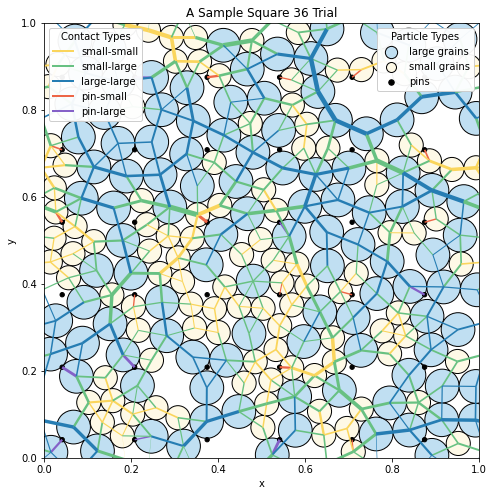

'squ-40176-266-36-0.0277-.1666667'

In [ ]:
plot_topography('squ36_08-05',3,title='A Sample Square 36 Trial', pins='all',bonds=True)

## 6.2. Animating Increasing Bond Strength Cutoff for a Trial/Identifying and Plotting Exceptionally Large Forces

In [0]:
import imageio
import os

for file in ['squ100_07-19']:
    print('FILE:', filenames[file])
    # Plotting exceptions
    for trialName in dataDict[file]['normalizedForce'].nlargest(10).index.get_level_values(0).unique():
        plot_topography(file, trialName, savefig='plots/exceptions', title='{} exception case, trial name {}'.format(file, trialName))

    # Creating Animations
    #for trialName in dataDict[file]['normalizedForce'].nlargest(10).index.get_level_values(0).unique():
    #    image_list=[]
    #    if not os.path.exists('Bond_Animations/'+trialName):
    #        os.makedirs('Bond_Animations/'+trialName)
    #    print('TRIAL:', trialName)
    #    for cutoffForce in [-100.0,-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1]:
    #        saveName=plot_topography(file, trialName, savefig='Bond_Animations/'+trialName, cutoff=cutoffForce, title='{} trial name {}, force cutoff {}'.format(file, trialName, np.abs(cutoffForce)))
    #        image_list.append(imageio.imread(saveName))
    #    imageio.mimwrite('Bond_Animations/{}/animated.gif'.format(trialName), image_list, duration = 2)

## 6.3. (Deprecated). Plotting lines directly in MatPlotLib
This code is fast, but plt.plot() can't account for varying line width; we end up using a LineCollection to do this in the next cell. Leaving this here for posterity.

In [ ]:
plt.figure(figsize=(8,8)) # large, square plot
# Plot internal bonds
plt.plot([internalBonds['x1'],internalBonds['x2']],[internalBonds['y1'],internalBonds['y2']],'C0')
# Plot bonds which wrap around boundary
plt.plot([wrapsY['x1'],wrapsY['x2']],[wrapsY['y1']-wrapsY['yAdjust'],wrapsY['y2']],'C3')
plt.plot([wrapsY['x1'],wrapsY['x2']],[wrapsY['y1'],wrapsY['y2']+wrapsY['yAdjust']],'C3')
plt.plot([wrapsX['x1']-wrapsX['xAdjust'],wrapsX['x2']],[wrapsX['y1'],wrapsX['y2']],'C1')
plt.plot([wrapsX['x1'],wrapsX['x2']+wrapsX['xAdjust']],[wrapsX['y1'],wrapsX['y2']],'C1')
# Change axis limits to size of simulation
plt.xlim(0,1)
plt.ylim(0,1)
#plt.savefig('plots/sampleNetwork.png',dpi=300)
plt.show()

## 6.4. (Deprecated). Plot with particleinfo.txt
A sample plotting of data from the last cell, with particles extrapolated from simulation_data/june_18/squ_BondInfo.txt, compared against a plot with particle types and locations explicitly given by a particleinfo.txt file. Note that with an additional file, we can pinpoint the location of rattlers and untouched pins.

0.0184348
0.0001


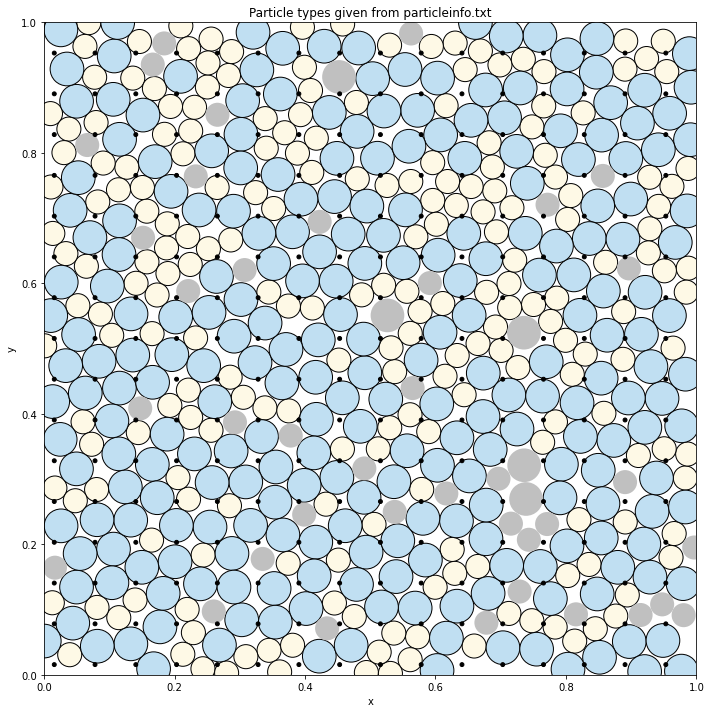

In [ ]:
from matplotlib import collections
colormap = matplotlib.cycler('color',['#FAD55C','#68C182','#267DB3','#ED6647','#8561C8','#000000', '#fef9e6', '#c0dff2']) # blue-yellow
plt.rc('axes',prop_cycle=colormap)

fig, ax2=plt.subplots(1, 1, figsize=(12,12))
# reading particleinfo file
particleInfo=pd.read_csv('/work/SwatGrains/simulation_data/feb_18/particleInfo_6.0.txt', sep=' ', header=None, names=['particle_number', 'x', 'y', 'radius', 'is_rattler', 'is_pin_or_rattler'],usecols=[1,2,3,4,5])
pin_radius, small_radius, large_radius = np.unique(particleInfo['radius'])
smallParticles = particleInfo[(particleInfo.radius==small_radius)&(particleInfo.is_rattler==0)]
largeParticles = particleInfo[(particleInfo.radius==large_radius)&(particleInfo.is_rattler==0)]
pins=particleInfo[particleInfo.radius==pin_radius]
rattlers=particleInfo[particleInfo.is_rattler==1]
print(small_radius)
print(pin_radius)
collection_smallParticles=collections.PatchCollection([plt.Circle((x,y), radius=small_radius) for x,y in smallParticles[['x','y']].values], ec='C5', fc='C6')
collection_largeParticles=collections.PatchCollection([plt.Circle((x,y), radius=large_radius) for x,y in largeParticles[['x','y']].values], ec='C5', fc='C7')
collection_pins=collections.PatchCollection([plt.Circle((x,y), radius=30*pin_radius) for x,y in pins[['x','y']].values], ec='k', fc='k')
collection_rattlers=collections.PatchCollection([plt.Circle((x,y), radius=r) for x,y,r in rattlers[['x','y','radius']].values], ec=None, fc='silver')

# Cosmetics
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Particle types given from particleinfo.txt')

ax2.set(aspect='equal')
ax2.add_collection(collection_smallParticles)
ax2.add_collection(collection_largeParticles)
ax2.add_collection(collection_rattlers)
ax2.add_collection(collection_pins)

# Particle legend
# can't directly label collections, so we designate shapes just for the legends
ax2.scatter([],[],facecolors='C7',edgecolors='C5', s=250, label='large grains')
ax2.scatter([],[],facecolors='C6',edgecolors='C5', s=100, label = 'small grains')
ax2.scatter([],[],facecolors='silver',edgecolors='silver',alpha=0.8, s=100, label = 'rattlers')
ax2.scatter([],[],c='k', s=30,label='pins')
#particleLegend2 = ax2.legend(loc='upper right',title='Particle Types',framealpha=0.95)

plt.savefig('plots/presentation_background.png',dpi=300)
plt.show()

## 6.5 (Deprecated). Plot contact force distribution as histogram for a single trial
Plots normalized contact forces $\frac{f}{\langle f\rangle}$ using seaborn's distplot() function. At this point, the y axis is not normalized; the kde parameter allows for normalization for a single data set, but to normalize the second plot collectively appears challenging.

In [ ]:
fig2 = plt.figure(figsize=(10,12))

hist1=fig2.add_subplot(2,1,1)
sns.distplot(bondInfo['normalizedForce'], hist=True, kde=False,
             bins=40, color = 'darkblue',
             hist_kws={'histtype':'step','linewidth':3,'alpha':0.95},
             #kde_kws={'linewidth': 0}
             )
hist1.set_xlim(-0.15,3.8)
hist1.set_title('force distribution of {} pin {} lattice, {} mobile, seed {}'.format(*[trialInfo[x] for x in ['pins','geometry','num','seed']]))
hist1.set_xlabel('')
#hist1.set_ylabel('probability density')

hist2=fig2.add_subplot(2,1,2)
bondInfo.groupby('bondType')['normalizedForce'].apply(lambda x: sns.distplot(x, hist=True, kde=False, bins=40, hist_kws={'histtype':'step','linewidth':3,'alpha':0.95}, label='bondType {}'.format(x.name)))
hist2.set_title('distribution by bond type')
hist2.set_xlabel('normalized contact forces')
hist2.set_xlim(-0.15,3.8)
hist2.legend()
#plt.savefig('plots/june_18_force_distribution_histogram.png', dpi=300)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=40884519-aebc-452e-98df-d99ef3ed7588' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>